# Load modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
sys.path.append("../src/")

from lbd_functions import printtimelogwithstarline,printtimelog,get_level_0_elem_ecdf,get_summary_stats_level_0,plot_summary_stats_level_0
from utils import get_ecdf_area_difference, get_ecdf, interpolate_ecdf, interp_ecdf_normalize_x

output_fd = '../data/boreholes-processed/'

# df_summary = pd.read_csv(output_fd+'LBW_extended_STRATA_LOG_summary.csv')
# df_processed_log = pd.read_csv(output_fd+'LBW_extended_STRATA_LOG_processed.csv')

# df_classified_log_fn = output_fd+'LBW_extended_STRATA_LOG_classified.csv'
# classification_fn = output_fd+'LBW_extended_STRATA_classification.csv'
# ref_err_fn = output_fd+'LBW_extended_error-tolerance.pickle'

df_summary = pd.read_csv(output_fd+'LBW_extended_STRATA_LOG_corrected_summary.csv')
df_processed_log = pd.read_csv(output_fd+'LBW_extended_STRATA_LOG_corrected_processed.csv')

df_classified_log_fn = output_fd+'LBW_extended_STRATA_LOG_corrected_classified.csv'
classification_fn = output_fd+'LBW_extended_STRATA_corrected_classification.csv'
ref_err_fn = output_fd+'LBW_extended_corrected_error-tolerance.pickle'



# Display first rows

In [2]:
df_summary[['RN','Easting','Northing']].head()
# len(df_summary)

,RN,Easting,Northing
0,20917,526047.920,7816871.202
1,20921,528027.083,7842476.233
2,20922,524216.073,7820972.989
3,20923,527924.188,7820920.088
4,20925,523511.176,7817625.662


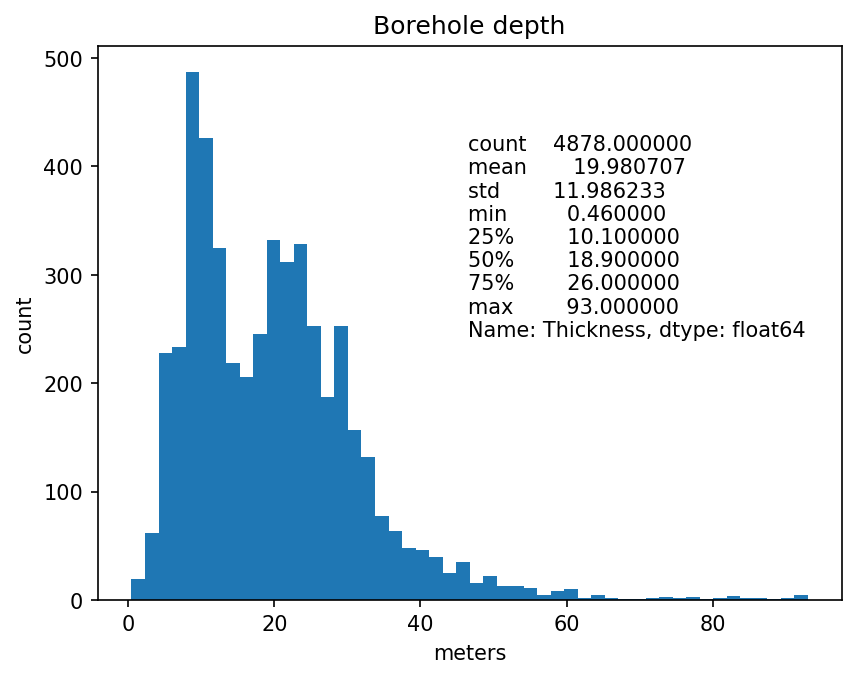

In [3]:
plt.figure(dpi=150)
count,bins,_ = plt.hist(df_summary['Thickness'],50)
plt.title('Borehole depth')
plt.xlabel('meters')
plt.ylabel('count')
plt.text(.5*bins.max(),.5*count.max(),str(df_summary['Thickness'].describe()))
plt.show()


In [4]:
df_processed_log[['RN','DESCR','TOP','BOTTOM', 'P1','P2','Material_Descriptor']]
# len(df_processed_log)

,RN,DESCR,TOP,BOTTOM,P1,P2,Material_Descriptor
0,20917,CLAY,0.00,15.80,CLAY,NONE,NONE
1,20917,GOOD GRAVEL 02 06 1969 SWL 15 80 M TMP NUL C...,15.80,22.20,GRAVEL,NONE,NONE
2,20921,TOP SOIL,0.00,3.96,SOIL,NONE,NONE
3,20921,CLAY,3.96,17.07,CLAY,NONE,NONE
4,20921,CLAY SILTY,17.07,17.37,CLAY,NONE,SILTY
...,...,...,...,...,...,...,...
38034,12100520,CLAY GREY HARD,21.20,22.00,CLAY,NONE,HARD
38035,12100521,CLAY DARK BROWN FIRM,0.00,1.70,CLAY,NONE,FIRM
38036,12100521,SAND LIGHT ORANGE BROWN FINETOMEDIUM COARSENS ...,1.70,3.00,SAND,NONE,NONE
38037,12100521,SAND LIGHT GREY FINETOMEDIUM GRAIN TO ABOUT 4 ...,3.00,6.80,SAND,NONE,NONE


# Check max score and score histogram

RN                  1.191106e+07
Latitude           -1.947869e+01
Longitude           1.474790e+02
Easting             5.502674e+05
Northing            7.846135e+06
Zone                5.500000e+01
Thickness           4.600000e+01
Total_Characters    3.167000e+03
Score               3.382903e-01
Name: 3569, dtype: float64
new max_char: [920.92]


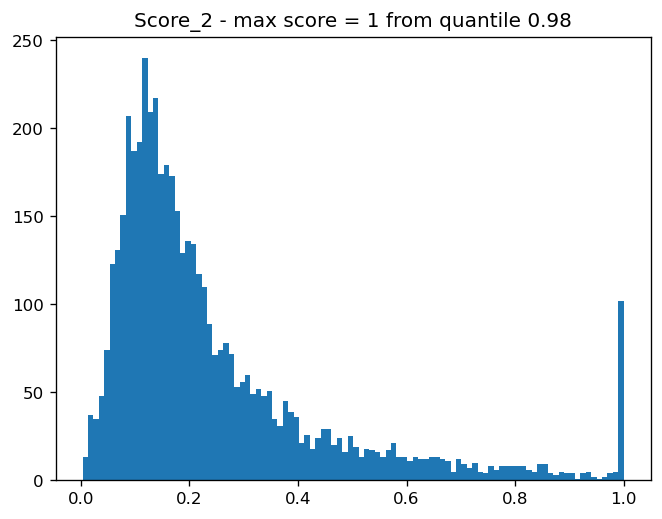

In [5]:
i_max_tot_char = df_summary['Total_Characters'].argmax()
print(df_summary.iloc[i_max_tot_char,:])

qmax=0.98
max_char = np.asarray(df_summary['Total_Characters'].quantile([qmax]))
print('new max_char: '+str(max_char))

df_summary['Score_2'] = np.minimum(np.asarray(df_summary['Total_Characters'].values/max_char).flatten(),np.ones(len(df_summary)))

plt.figure(dpi=120),plt.title('Score_2 - max score = 1 from quantile '+str(qmax))
histplot_df_summary=plt.hist(df_summary['Score_2'].values,100)
plt.show()

# Analysis by components

In [6]:
df_processed_log.groupby(['Material_Descriptor'],as_index=False).size() # P1, P2, Material_Descriptor

,Material_Descriptor,size
0,CLAYBOUND,565
1,"CLAYBOUND, FIRM",3
2,"CLAYBOUND, HARD",5
3,"CLAYBOUND, SANDY",5
4,"CLAYBOUND, SILTY",7
...,...,...
178,"WEATHERED, SANDY, CLAYEY",1
179,"WEATHERED, SANDY, FIRM",1
180,"WEATHERED, SANDY, GRAVELLY",3
181,"WEATHERED, SILTY",1


In [7]:
df_P1P2_combinations = df_processed_log.groupby(['P1','P2'],as_index=False).size()
df_P1P2_combinations.to_csv(output_fd+'P1P2_combinations.csv')

df_P1P2MD_combinations = df_processed_log.groupby(['P1','P2','Material_Descriptor'],as_index=False).size()
df_P1P2MD_combinations.to_csv(output_fd+'P1P2MD_combinations.csv')


# display for a selected major component
df_P1P2_combinations[df_P1P2_combinations['P1']=='SAND'] # BASEMENT CLAY COBBLES FILL GRAVEL ....

,P1,P2,size
75,SAND,BASEMENT,71
76,SAND,CLAY,981
77,SAND,COBBLES,1331
78,SAND,FILL,2
79,SAND,GRAVEL,2758
80,SAND,LIMESTONE OR CALCRETE,10
81,SAND,LOAM,12
82,SAND,MUD,21
83,SAND,NONE,8867
84,SAND,ROCK,5


In [8]:
dh_end = df_processed_log.groupby(['RN'],as_index=False)['BOTTOM'].max()
dh_end.rename(columns={"BOTTOM": "DH_END"},inplace=True)
dh_end

,RN,DH_END
0,20917,22.20
1,20921,32.92
2,20922,21.34
3,20923,32.92
4,20925,22.40
...,...,...
4873,12100517,10.00
4874,12100518,18.70
4875,12100519,21.00
4876,12100520,22.00


In [9]:
df_processed_log2 = df_processed_log.merge(dh_end,left_on='RN',right_on='RN')
df_processed_log2['thickness'] = df_processed_log2['BOTTOM'].values - df_processed_log2['TOP'].values
df_processed_log2['depth_abs'] = (df_processed_log2['BOTTOM'].values + df_processed_log2['TOP'].values)/2
df_processed_log2['depth_rel'] = (df_processed_log2['BOTTOM'].values + df_processed_log2['TOP'].values)/(2*df_processed_log2['DH_END'].values)

tmp = df_processed_log2[(df_processed_log2['P1']=='CLAY') & (df_processed_log2['P2']=='SAND')]
tmp.head()

,RN,REC,DESCR,TOP,BOTTOM,Thickness,Latitude,Longitude,Easting,Northing,...,P1,P2,Material_Descriptor,grain_size,Colour1,Colour2,DH_END,thickness,depth_abs,depth_rel
133,20939,2,CLAY AND SAND,0.61,1.83,1.22,-19.712655,147.239098,525056.027,7820298.145,...,CLAY,SAND,NONE,NONE,NONE,NONE,26.21,1.22,1.220,0.046547
213,20950,2,CLAY BROWN WITH SAND AT BOTTOM,1.52,6.10,4.58,-19.763987,147.230245,524120.573,7814619.158,...,CLAY,SAND,NONE,NONE,BROWN,NONE,24.38,4.58,3.810,0.156276
214,20950,3,FINE GRAINED BROWN COLOURED SANDY CLAY WITH IN...,6.10,9.14,3.04,-19.763987,147.230245,524120.573,7814619.158,...,CLAY,SAND,SANDY,FINE,BROWN,NONE,24.38,3.04,7.620,0.312551
236,20959,4,CLAY AND SAND,57.00,64.00,7.00,-19.705665,147.233566,524477.368,7821072.445,...,CLAY,SAND,NONE,NONE,NONE,NONE,82.00,7.00,60.500,0.737805
317,25562,5,CLAY STICKY WHITE WITH A BIT OF SAND,6.10,8.23,2.13,-19.859002,147.631650,566091.000,7803929.000,...,CLAY,SAND,NONE,NONE,WHITE,NONE,21.34,2.13,7.165,0.335754


In [10]:
ix_thickness_lt00 = np.asarray(np.where(df_processed_log2['thickness']<0)).flatten()
print(str(len(ix_thickness_lt00))+' rows with negative thickness')
df_processed_log2.iloc[ix_thickness_lt00,:]

0 rows with negative thickness


,RN,REC,DESCR,TOP,BOTTOM,Thickness,Latitude,Longitude,Easting,Northing,...,P1,P2,Material_Descriptor,grain_size,Colour1,Colour2,DH_END,thickness,depth_abs,depth_rel


In [11]:
gtth = 70
ix_thickness_gtth = np.asarray(np.where(df_processed_log2['thickness']>gtth)).flatten()
print(str(len(ix_thickness_gtth))+' rows with thickness greater than '+str(gtth)+'m')
df_processed_log2.iloc[ix_thickness_gtth,:]

0 rows with thickness greater than 70m


,RN,REC,DESCR,TOP,BOTTOM,Thickness,Latitude,Longitude,Easting,Northing,...,P1,P2,Material_Descriptor,grain_size,Colour1,Colour2,DH_END,thickness,depth_abs,depth_rel


In [12]:
ix2drop = np.concatenate((ix_thickness_lt00,ix_thickness_gtth))
df_processed_log3 = df_processed_log2.drop(ix2drop).reset_index(drop=True)
df_processed_log3

,RN,REC,DESCR,TOP,BOTTOM,Thickness,Latitude,Longitude,Easting,Northing,...,P1,P2,Material_Descriptor,grain_size,Colour1,Colour2,DH_END,thickness,depth_abs,depth_rel
0,20917,1,CLAY,0.00,15.80,15.80,-19.743611,147.248611,526047.920,7816871.202,...,CLAY,NONE,NONE,NONE,NONE,NONE,22.20,15.80,7.900,0.355856
1,20917,2,GOOD GRAVEL 02 06 1969 SWL 15 80 M TMP NUL C...,15.80,22.20,6.40,-19.743611,147.248611,526047.920,7816871.202,...,GRAVEL,NONE,NONE,NONE,NONE,NONE,22.20,6.40,19.000,0.855856
2,20921,1,TOP SOIL,0.00,3.96,3.96,-19.512192,147.267118,528027.083,7842476.233,...,SOIL,NONE,NONE,NONE,NONE,NONE,32.92,3.96,1.980,0.060146
3,20921,2,CLAY,3.96,17.07,13.11,-19.512192,147.267118,528027.083,7842476.233,...,CLAY,NONE,NONE,NONE,NONE,NONE,32.92,13.11,10.515,0.319411
4,20921,3,CLAY SILTY,17.07,17.37,0.30,-19.512192,147.267118,528027.083,7842476.233,...,CLAY,NONE,SILTY,NONE,NONE,NONE,32.92,0.30,17.220,0.523086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38034,12100520,14,CLAY GREY HARD,21.20,22.00,0.80,-19.715700,147.388904,540754.172,7819932.169,...,CLAY,NONE,HARD,NONE,GREY,NONE,22.00,0.80,21.600,0.981818
38035,12100521,1,CLAY DARK BROWN FIRM,0.00,1.70,1.70,-19.754287,147.429180,544964.047,7815652.000,...,CLAY,NONE,FIRM,NONE,BROWN,NONE,7.40,1.70,0.850,0.114865
38036,12100521,2,SAND LIGHT ORANGE BROWN FINETOMEDIUM COARSENS ...,1.70,3.00,1.30,-19.754287,147.429180,544964.047,7815652.000,...,SAND,NONE,NONE,MEDIUM TO COARSE,ORANGE,BROWN,7.40,1.30,2.350,0.317568
38037,12100521,5,SAND LIGHT GREY FINETOMEDIUM GRAIN TO ABOUT 4 ...,3.00,6.80,3.80,-19.754287,147.429180,544964.047,7815652.000,...,SAND,NONE,NONE,MEDIUM TO COARSE,GREY,NONE,7.40,3.80,4.900,0.662162


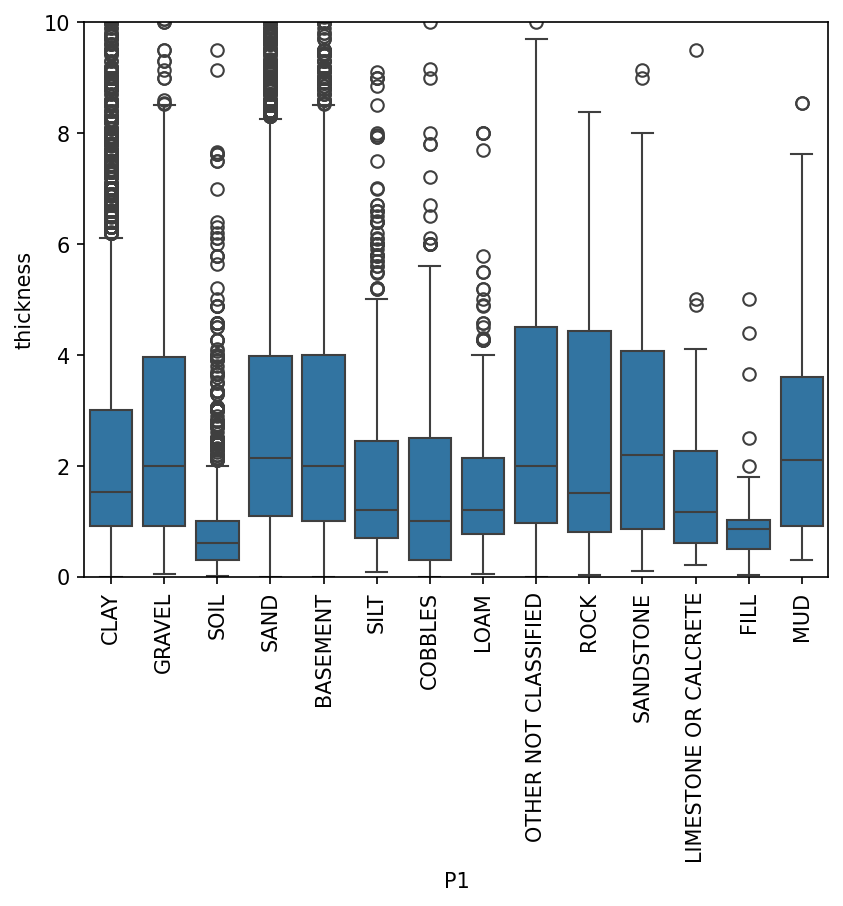

In [13]:
plt.figure(dpi=150)
sns.boxplot(data=df_processed_log3,x='P1',y='thickness') # boxplot violinplot
plt.ylim([0,10])
plt.xticks(rotation=90)
plt.show()

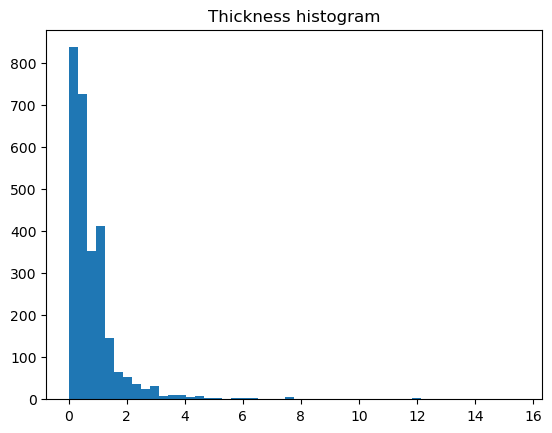

15.54
RN                                             20948
REC                                                1
DESCR                  TOP SOIL CLAY FINE SILTY SAND
TOP                                              0.0
BOTTOM                                         15.54
Thickness                                      15.54
Latitude                                   -19.77486
Longitude                                 147.210355
Easting                                   522035.386
Northing                                 7813418.686
Projecti_1                                        55
P1                                              SOIL
P2                                              CLAY
Material_Descriptor                            SILTY
grain_size                                      FINE
Colour1                                         NONE
Colour2                                         NONE
DH_END                                         28.86
thickness                               

,RN,REC,DESCR,TOP,BOTTOM,Thickness,Latitude,Longitude,Easting,Northing,...,P1,P2,Material_Descriptor,grain_size,Colour1,Colour2,DH_END,thickness,depth_abs,depth_rel
2,20921,1,TOP SOIL,0.0,3.96,3.96,-19.512192,147.267118,528027.083,7842476.233,...,SOIL,NONE,NONE,NONE,NONE,NONE,32.92,3.96,1.98,0.060146
9,20922,1,TOP SOIL,0.0,0.30,0.30,-19.706567,147.231074,524216.073,7820972.989,...,SOIL,NONE,NONE,NONE,NONE,NONE,21.34,0.30,0.15,0.007029
16,20923,1,TOP SOIL,0.0,0.30,0.30,-19.706996,147.266458,527924.188,7820920.088,...,SOIL,NONE,NONE,NONE,NONE,NONE,32.92,0.30,0.15,0.004557
36,20926,1,SOIL AND CLAY,0.0,3.96,3.96,-19.729132,147.235644,524691.537,7818475.351,...,SOIL,CLAY,NONE,NONE,NONE,NONE,21.95,3.96,1.98,0.090205
42,20927,1,SOIL,0.0,0.30,0.30,-19.705303,147.267636,528047.935,7821107.237,...,SOIL,NONE,NONE,NONE,NONE,NONE,36.40,0.30,0.15,0.004121


In [14]:
tmp = df_processed_log2[(df_processed_log2['P1']=='SOIL')]
plt.figure(dpi=100),plt.title('Thickness histogram')
plt.hist(tmp['thickness'],50),plt.show()
print(tmp['thickness'].max())
imax = tmp['thickness'].argmax()
print(tmp.iloc[imax,:])

tmp.head()

### Group by levels

In [15]:
# Define classification from the pptx slide as a list of :
# ['level_0','level_1','P1','COND2_P2_OR_MD']
# Level 0 defined by P1 (primary principal material)
# Level 1 defined by P2 (secondary principal material) OR MD (material descriptor)
data = [['Sands','Sand','SAND','NONE'],
        ['Sands','Sand','SAND','COBBLES'],
        ['Sands','Sand','SAND','GRAVEL'],
        ['Sands','Gravel','GRAVEL','NONE'],
        ['Sands','Gravel','GRAVEL','COBBLES'],
        ['Sands','Gravel','GRAVEL','CLAY'],
        ['Sands','Gravel','GRAVEL','SAND'],
        ['Sands','Gravel','COBBLES','NONE'],
        ['Sands','Gravel','COBBLES','GRAVEL'],
        ['Sands','Gravel','COBBLES','SAND'],
        ['Clay','Clay','CLAY','NONE'],
        ['Clay','Clay','CLAY','SILT'],
        ['Clay','Clay','CLAY','SILTY'],
        ['Clay','Mud','MUD','NONE'],
        ['Clay','Mud','MUD','GRAVEL'],
        ['Clay','Silt','SILT','NONE'],
        ['Clay','Silt','SILT','CLAY'],
        ['Clay','Silt','SILT','COBBLES'],
        ['Clay','Silt','SILT','GRAVEL'],
        ['Intermediate','Soil','SOIL','NONE'],
        ['Intermediate','Soil','SOIL','SAND'],
        ['Intermediate','Soil','SOIL','SANDY'],
        ['Intermediate','Soil','SOIL','COBBLES'],
        ['Intermediate','Soil','SOIL','CLAY'],
        ['Intermediate','Soil','SOIL','CLAYEY'],
        ['Intermediate','Soil','SOIL','SILT'],        
        ['Intermediate','Loam','LOAM','NONE'],
        ['Intermediate','Loam','LOAM','CLAY'],
        ['Intermediate','Loam','LOAM','CLAYEY'],
        ['Intermediate','Loam','LOAM','SANDY'],
        ['Intermediate','Loam','LOAM','SILTY'],      
        ['Intermediate','Fill','FILL','NONE'],
        ['Intermediate','Fill','FILL','GRAVEL'],
        ['Intermediate','Fill','FILL','SAND'],
        ['Intermediate','Variation of Sand','SAND','CLAY'],
        ['Intermediate','Variation of Sand','SAND','CLAYEY'],
        ['Intermediate','Variation of Sand','SAND','SILT'],
        ['Intermediate','Variation of Sand','SAND','SILTY'],
        ['Intermediate','Variation of Sand','SAND','LOAM'],
        ['Intermediate','Variation of Sand','SAND','LOAMY'],
        ['Intermediate','Variation of Sand','SAND','MUD'],
        ['Intermediate','Variation of Clay','CLAY','SAND'],
        ['Intermediate','Variation of Clay','CLAY','GRAVEL'],
        ['Intermediate','Variation of Clay','CLAY','GRAVELLY'],
        ['Intermediate','Variation of Clay','CLAY','COBBLES'],
        ['Intermediate','Variation of Clay','CLAY','LOAM'],
        ['Intermediate','Variation of Clay','CLAY','LOAMY'],
        ['Intermediate','Variation of Clay','CLAY','SOIL'],
        ['Intermediate','Variation of Clay','CLAY','FILL'],
        ['Intermediate','Variation of Clay','CLAY','MUD'],      
        ['Weathered basement','Sandstone','SANDSTONE','NONE'],
        ['Weathered basement','Sandstone','SANDSTONE','SAND'],
        ['Weathered basement','Sandstone','SANDSTONE','GRAVEL'],
        ['Weathered basement','Sandstone','SANDSTONE','SILT'],
        ['Weathered basement','Limestone','LIMESTONE OR CALCRETE','NONE'],
        ['Weathered basement','Rock','ROCK','NONE'],
        ['Weathered basement','Rock','ROCK','SAND'],
        ['Weathered basement','Rock','ROCK','CLAY'],
        ['Weathered basement','Weathered basement','BASEMENT','WEATHERED'],
        ['Weathered basement','Weathered basement','BASEMENT','FRACTURED'],
        ['Weathered basement','Weathered basement','BASEMENT','COBBLES'],
        ['Basement','Basement','BASEMENT','NONE'],
        ['Basement','Basement','BASEMENT','FIRM'],
        ['Basement','Basement','BASEMENT','HARD'],
        ['Basement','Basement','BASEMENT','CLAY'],
    ]
classification = pd.DataFrame(data,columns=['level_0','level_1','P1','COND2_P2_OR_MD'])

ix_duplicates = np.asarray(np.where(classification.groupby(['P1','COND2_P2_OR_MD'],as_index=False).size()['size']>1)).flatten()

if len(ix_duplicates):
    print('Some classification duplicates exist:')
    classification.loc[ix_duplicates,:]
else:
    print('No classification duplicates.')

# save to csv
classification.to_csv(classification_fn)

No classification duplicates.


In [16]:
# classify rows of df_processed_log2 and df_processed_log3
for i in range(len(classification)):
    cur_level_0,cur_level_1,cur_P1,cur_COND2 = classification.loc[i,:].values
    #print('cur_level_0: '+cur_level_0+'\n'+'cur_level_1: '+cur_level_1+'\n'+'cur_P1: '+cur_P1+'\n'+'cur_COND2: '+cur_COND2)
    ix = np.asarray(np.where((df_processed_log2['P1']==cur_P1) & ( (df_processed_log2['P2']==cur_COND2)|(df_processed_log2['Material_Descriptor'].str.contains(cur_COND2)) ) )).flatten()
    df_processed_log2.loc[ix,'level_0'] = cur_level_0
    df_processed_log2.loc[ix,'level_1'] = cur_level_1
    #df_processed_log2.loc[ix,['P1','P2','Material_Descriptor','level_0','level_1']]
    
    ix = np.asarray(np.where((df_processed_log3['P1']==cur_P1) & ( (df_processed_log3['P2']==cur_COND2)|(df_processed_log3['Material_Descriptor'].str.contains(cur_COND2)) ) )).flatten()
    df_processed_log3.loc[ix,'level_0'] = cur_level_0
    df_processed_log3.loc[ix,'level_1'] = cur_level_1
    #df_processed_log3.loc[ix,['P1','P2','Material_Descriptor','level_0','level_1']]
    
    

In [17]:
# save df_processed_log3
df_processed_log3.to_csv(df_classified_log_fn)

In [18]:
# find rows not cassiffied in df_processed_log2
ix = np.asarray(np.where((df_processed_log2['level_0'].isnull())|(df_processed_log2['level_1'].isnull()))).flatten()
print('Unclassified rows, by principal compenents and material derciptor: ')
df_processed_log2.loc[ix,:].groupby(['P1','P2','Material_Descriptor'],as_index=False).size()

Unclassified rows, by principal compenents and material derciptor: 


,P1,P2,Material_Descriptor,size
0,BASEMENT,MUD,HEAVY,1
1,CLAY,BASEMENT,FIRM,1
2,CLAY,BASEMENT,"FIRM, WEATHERED",1
3,CLAY,BASEMENT,FRACTURED,1
4,CLAY,BASEMENT,GRITTY,4
5,CLAY,BASEMENT,"GRITTY, WEATHERED",2
6,CLAY,BASEMENT,HARD,2
7,CLAY,BASEMENT,"HARD, WEATHERED",1
8,CLAY,BASEMENT,WEATHERED,34
9,CLAY,LIMESTONE OR CALCRETE,FIRM,1


In [19]:
# find rows not cassiffied in df_processed_log3
ix = np.asarray(np.where((df_processed_log3['level_0'].isnull())|(df_processed_log3['level_1'].isnull()))).flatten()
print('Unclassified rows, by principal compenents and material derciptor: ')
df_processed_log3.loc[ix,:].groupby(['P1','P2','Material_Descriptor'],as_index=False).size()

Unclassified rows, by principal compenents and material derciptor: 


,P1,P2,Material_Descriptor,size
0,BASEMENT,MUD,HEAVY,1
1,CLAY,BASEMENT,FIRM,1
2,CLAY,BASEMENT,"FIRM, WEATHERED",1
3,CLAY,BASEMENT,FRACTURED,1
4,CLAY,BASEMENT,GRITTY,4
5,CLAY,BASEMENT,"GRITTY, WEATHERED",2
6,CLAY,BASEMENT,HARD,2
7,CLAY,BASEMENT,"HARD, WEATHERED",1
8,CLAY,BASEMENT,WEATHERED,34
9,CLAY,LIMESTONE OR CALCRETE,FIRM,1


### Depth scatter / density plots by category for levels 0 and 1

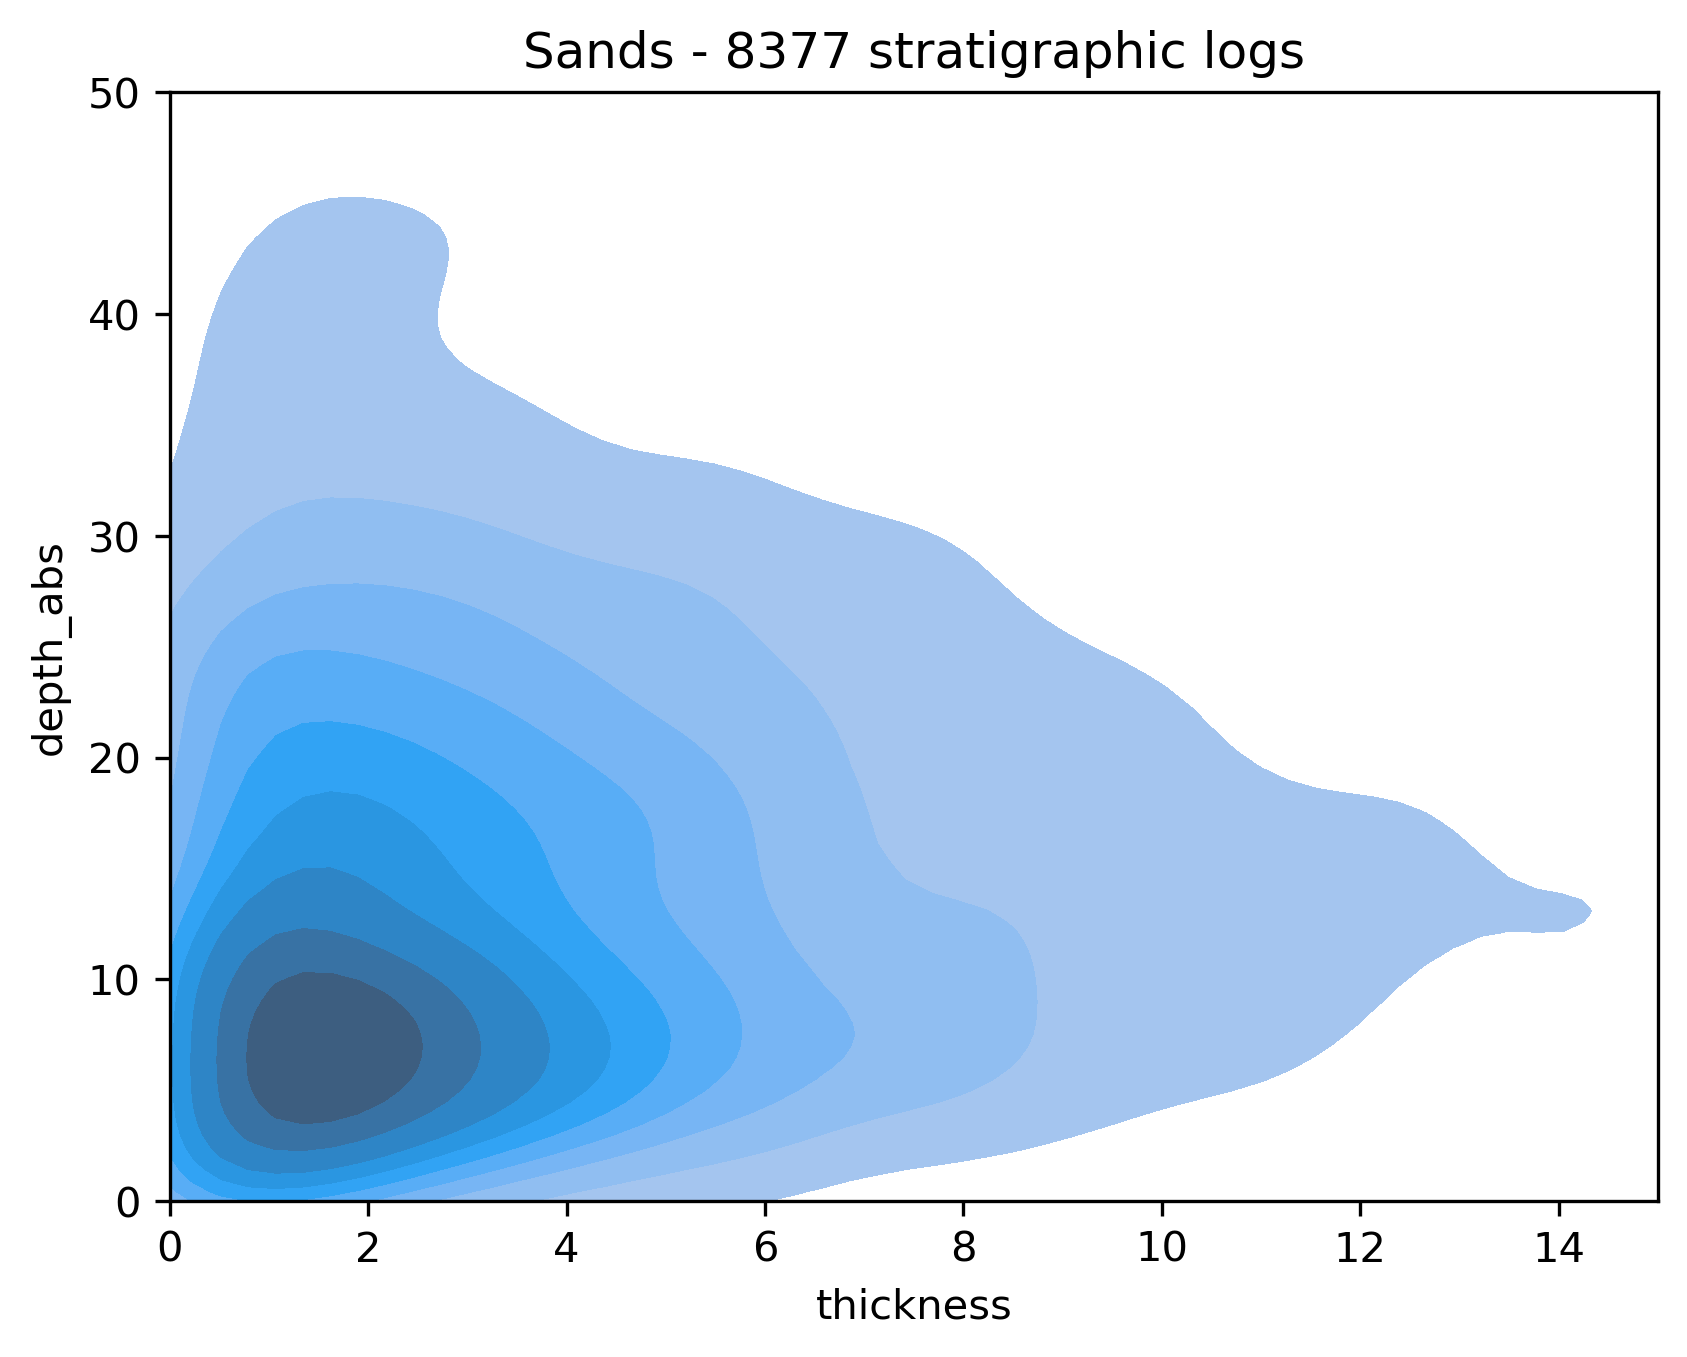

In [20]:
def plot_thickness_depth_density(df,level_0,xlim=None,ylim=None):
    cur_ix = np.asarray(np.where(df['level_0']==level_0)).flatten()
    cur_thickness = df.loc[cur_ix,'thickness']
    cur_depth_abs = df.loc[cur_ix,'depth_abs']

    plt.figure(dpi=300)
    sns.kdeplot(
        data=df.loc[cur_ix,['thickness','depth_abs']], x="thickness", y="depth_abs", fill=True,
    )
    plt.title(cur_level_0+' - '+str(len(cur_ix))+' stratigraphic logs')
    if xlim is not None: plt.xlim(xlim)
    if ylim is not None: plt.ylim(ylim)
    plt.show()
    return

cur_level_0 = 'Sands'
thickness_lim = [0,15]
depth_lim = [0,50]
plot_thickness_depth_density(df_processed_log3,cur_level_0,thickness_lim,depth_lim)

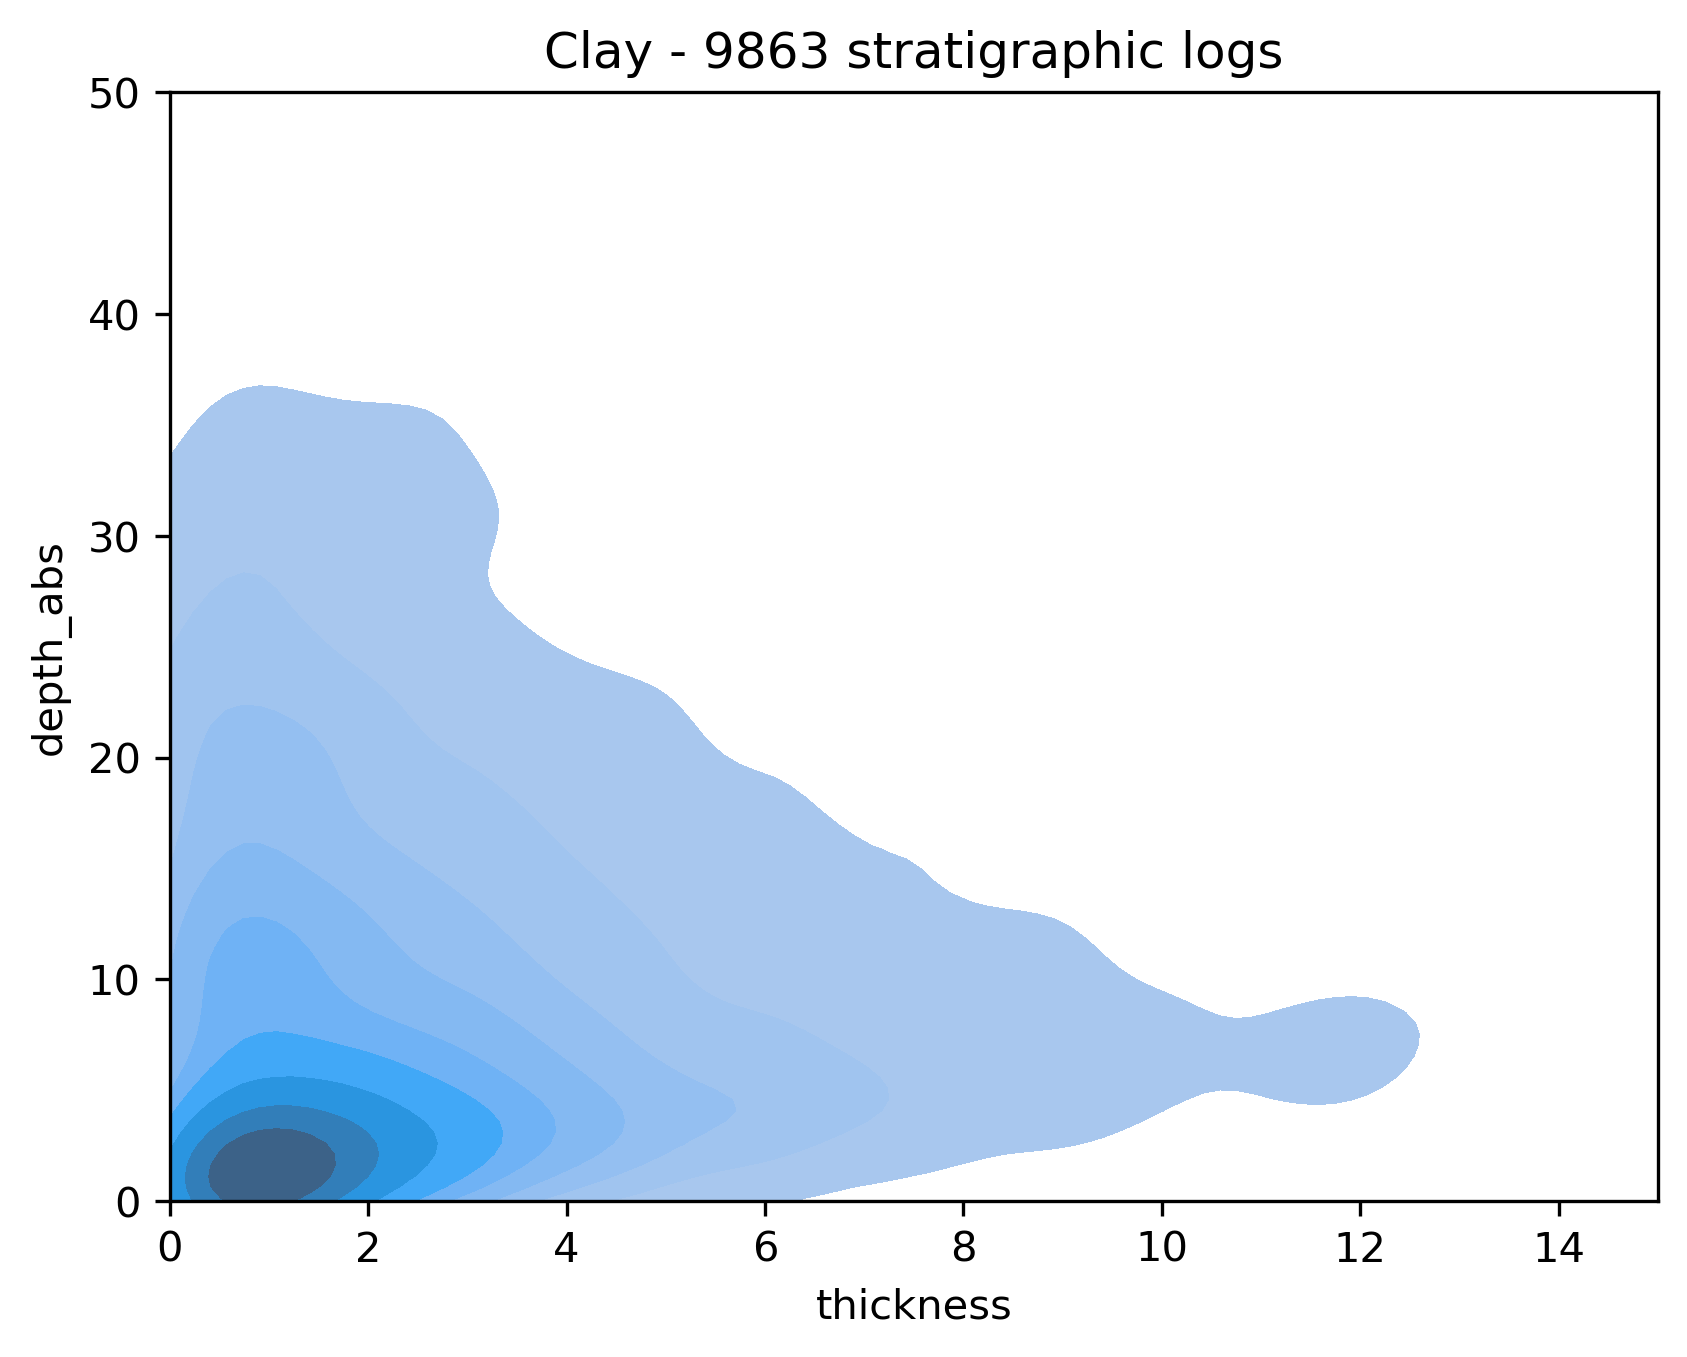

In [21]:
cur_level_0 = 'Clay'
thickness_lim = [0,15]
depth_lim = [0,50]
plot_thickness_depth_density(df_processed_log3,cur_level_0,thickness_lim,depth_lim)

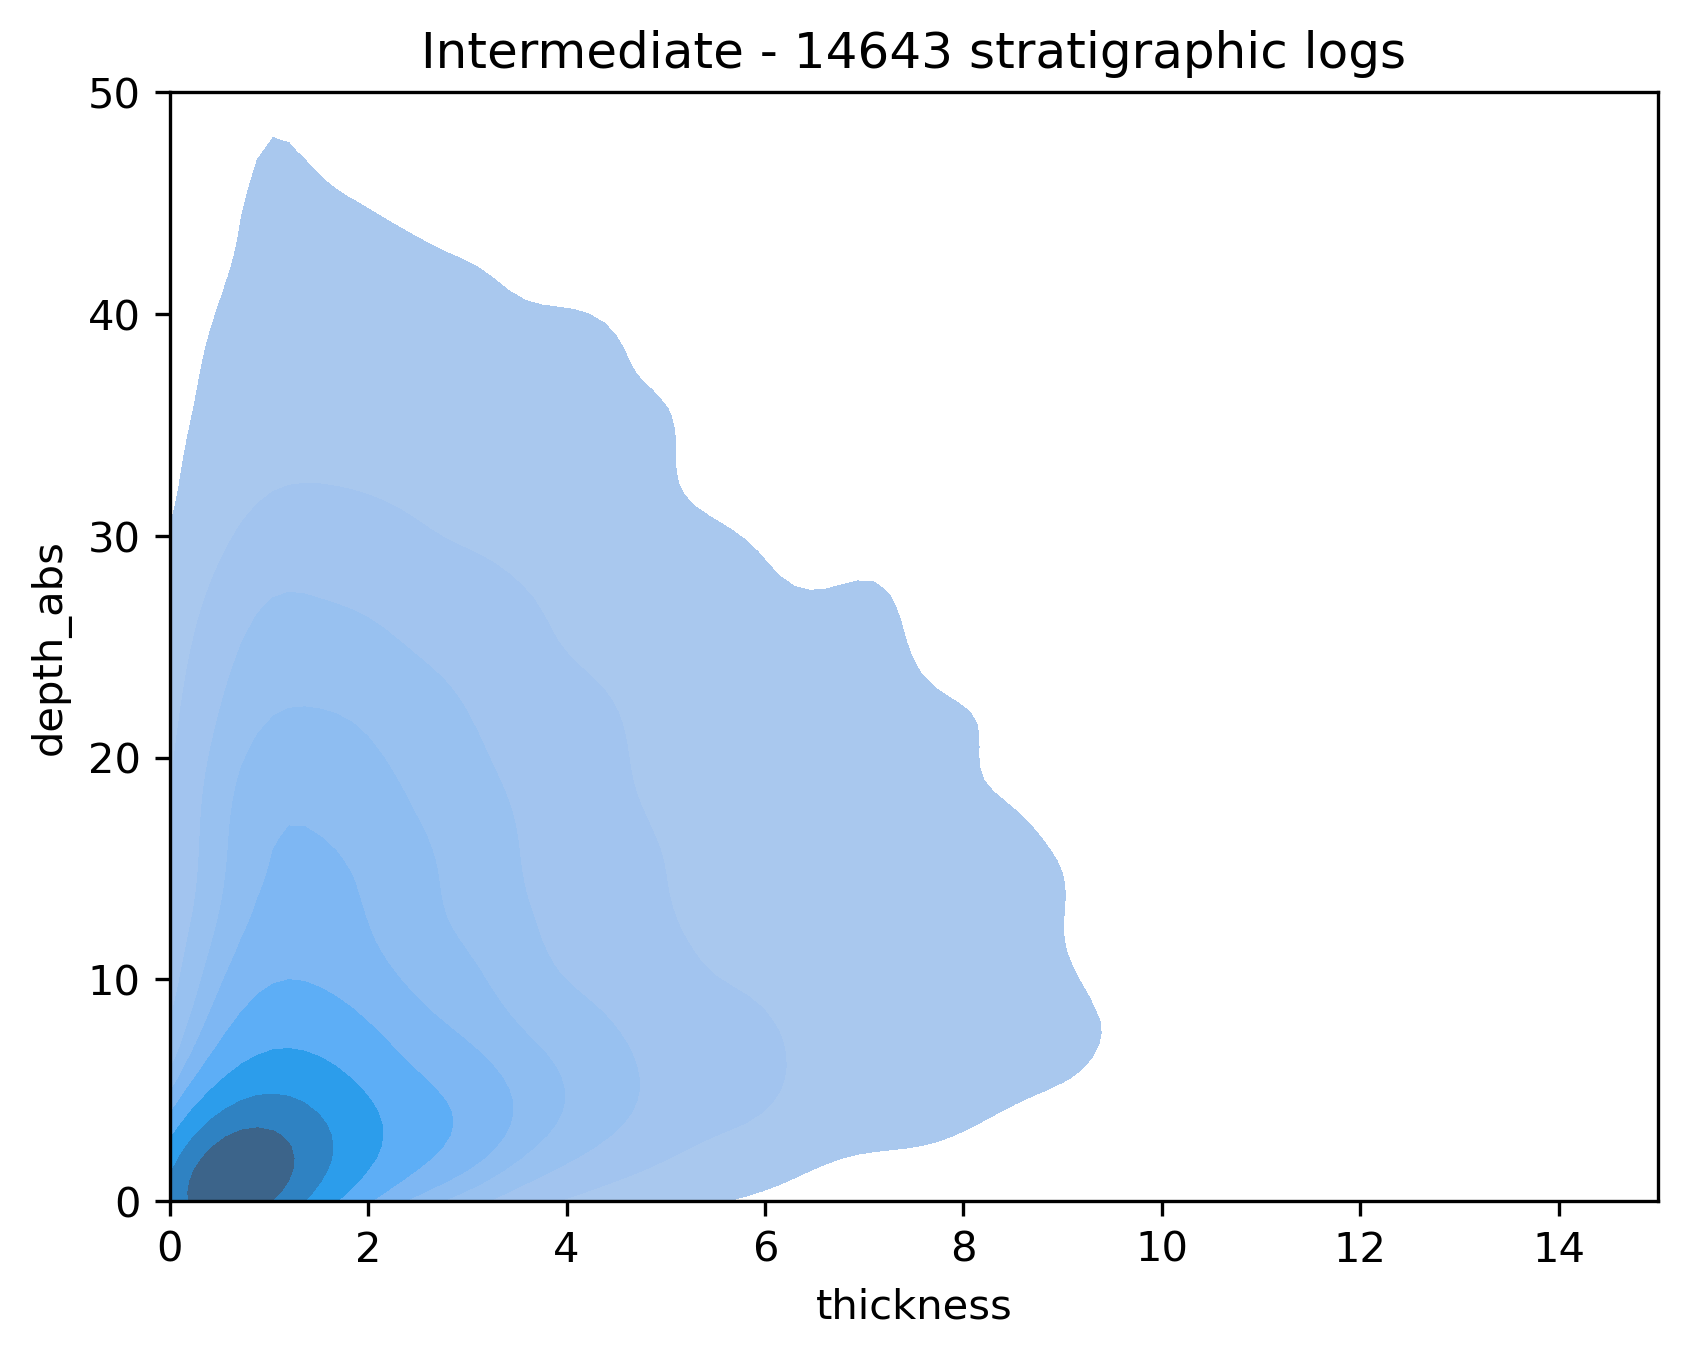

In [22]:
cur_level_0 = 'Intermediate'
thickness_lim = [0,15]
depth_lim = [0,50]
plot_thickness_depth_density(df_processed_log3,cur_level_0,thickness_lim,depth_lim)

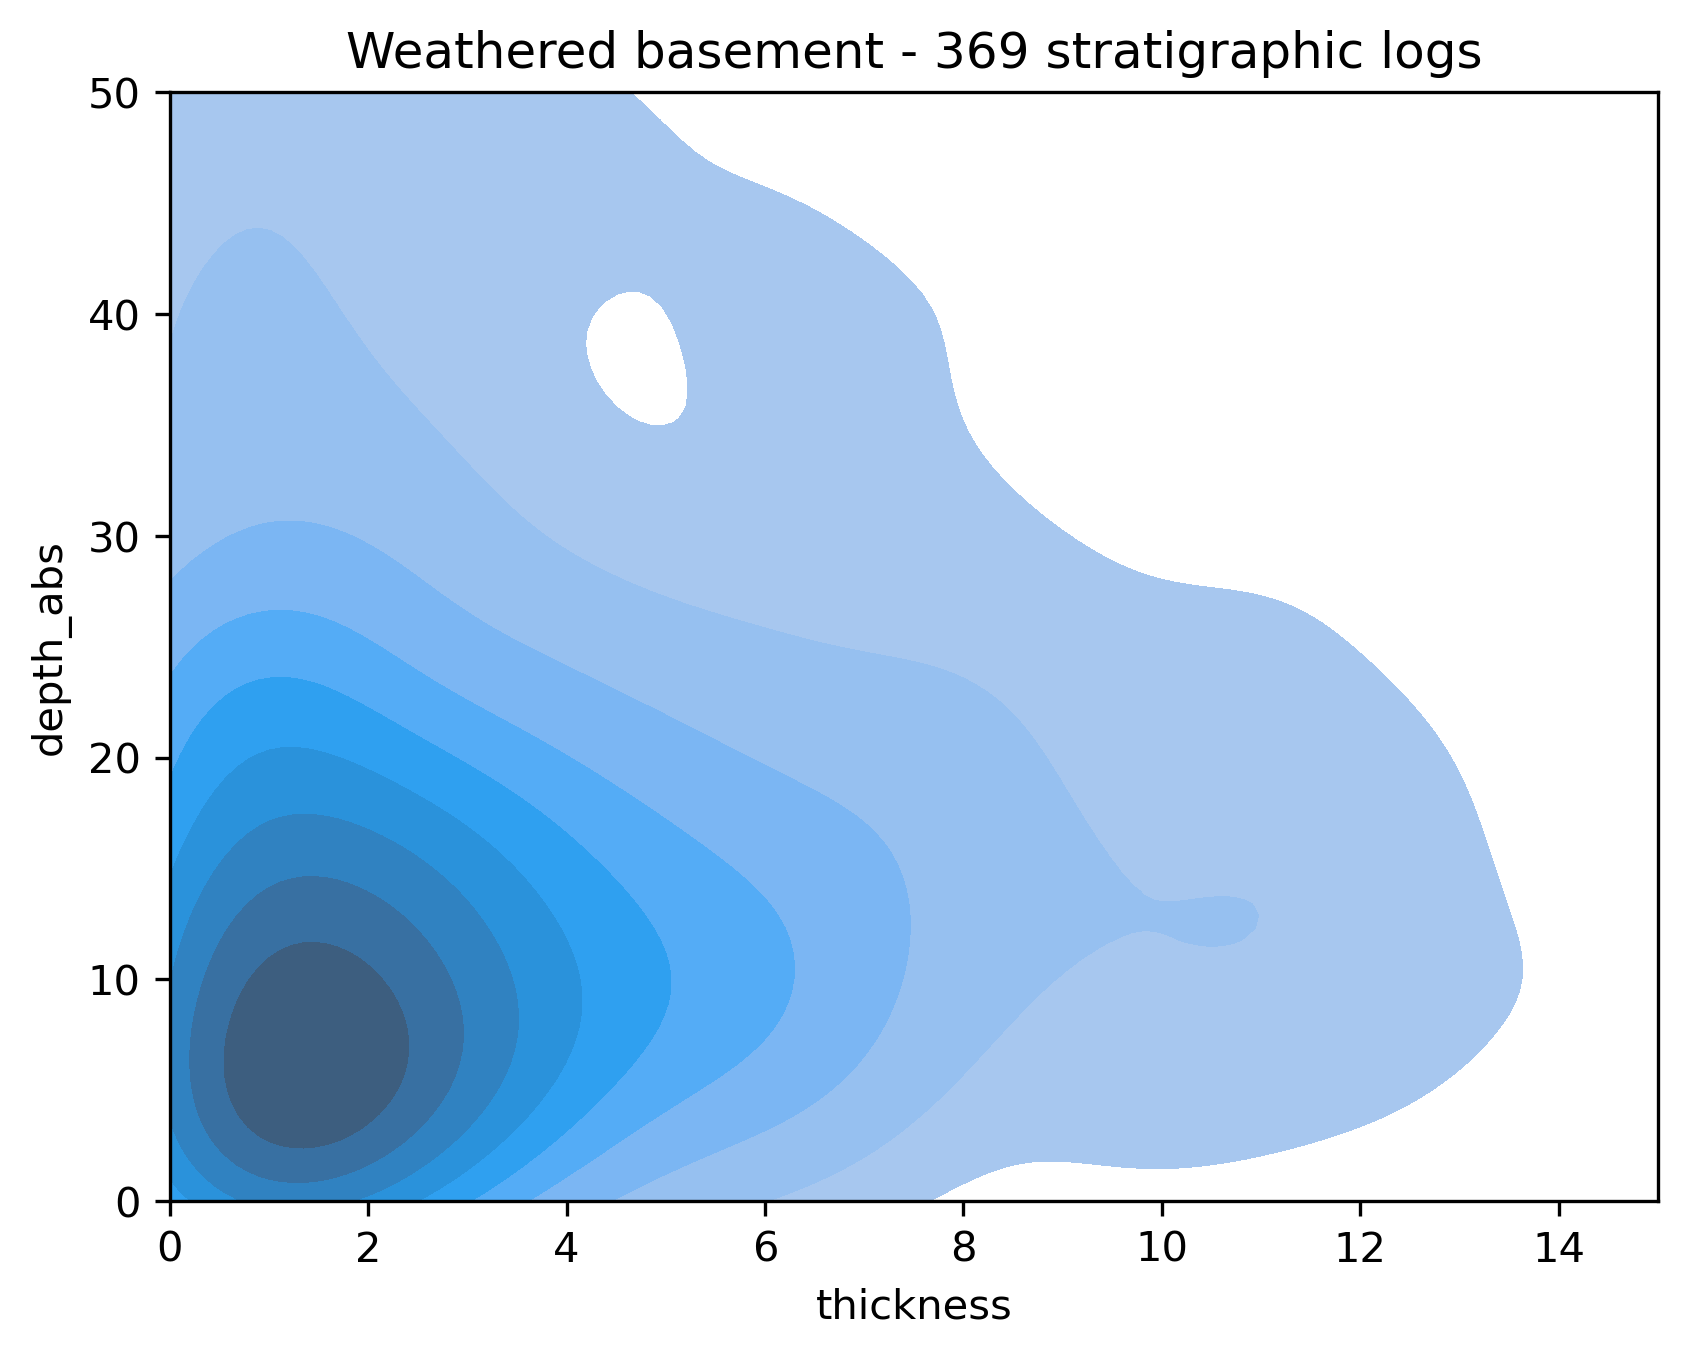

In [23]:
cur_level_0 = 'Weathered basement'
thickness_lim = [0,15]
depth_lim = [0,50]
plot_thickness_depth_density(df_processed_log3,cur_level_0,thickness_lim,depth_lim)

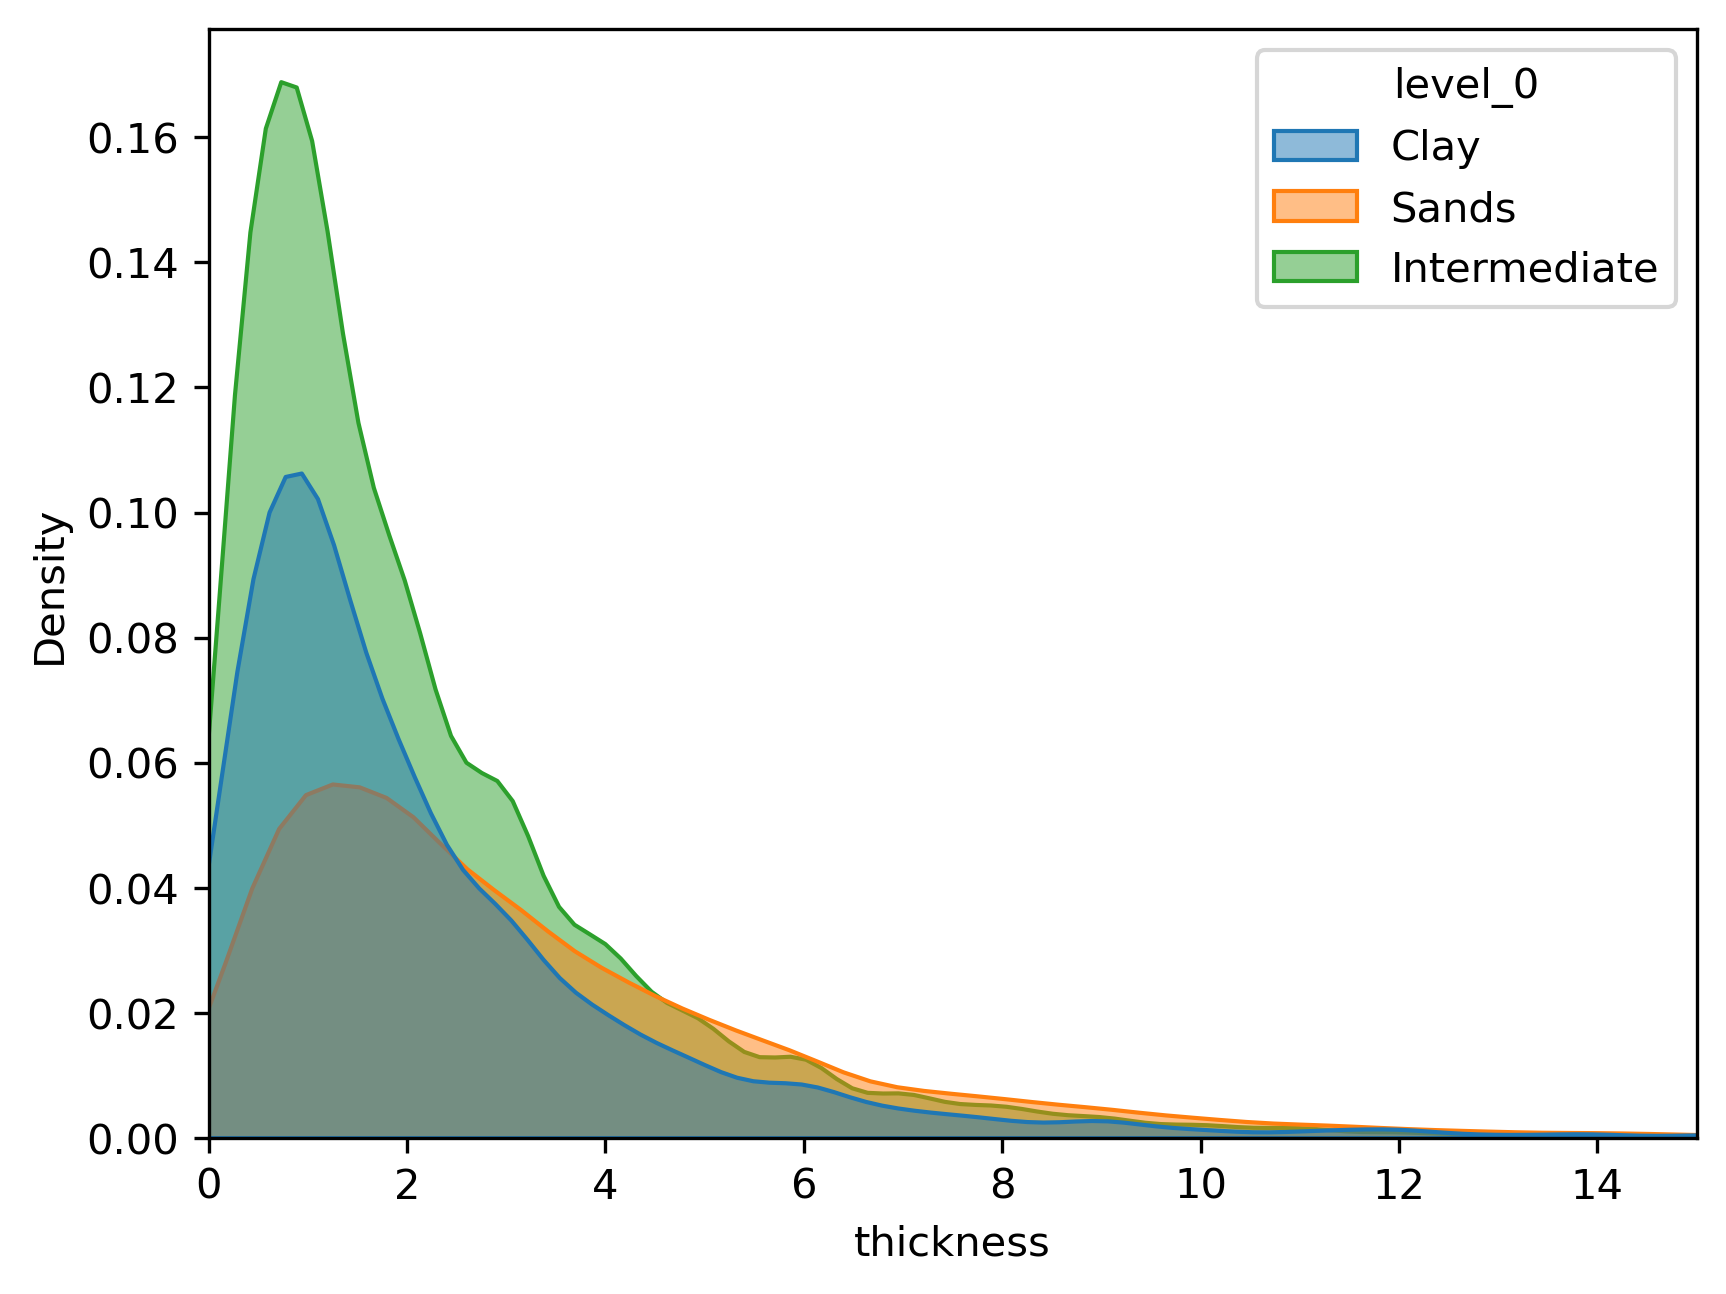

In [24]:
thickness_lim = [0,15]
depth_lim = [0,50]

ix = np.asarray(np.where(
    (df_processed_log3['level_0']!='Basement') & 
    (df_processed_log3['level_0']!='Weathered basement')
)).flatten()

plt.figure(dpi=300)
sns.kdeplot(
    data=df_processed_log3.loc[ix,:], x="thickness", hue="level_0", fill=True,alpha=0.5 #, y="depth_abs"
)
plt.xlim(thickness_lim)
# plt.ylim(depth_lim)
plt.show()

### Summary by classification level

C:\Users\00102908\my-UWA\LBD-facies-modeling\notebooks\../src\lbd_functions.py:717: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Intermediate','\n Coarse-grained','Fine-grained'])


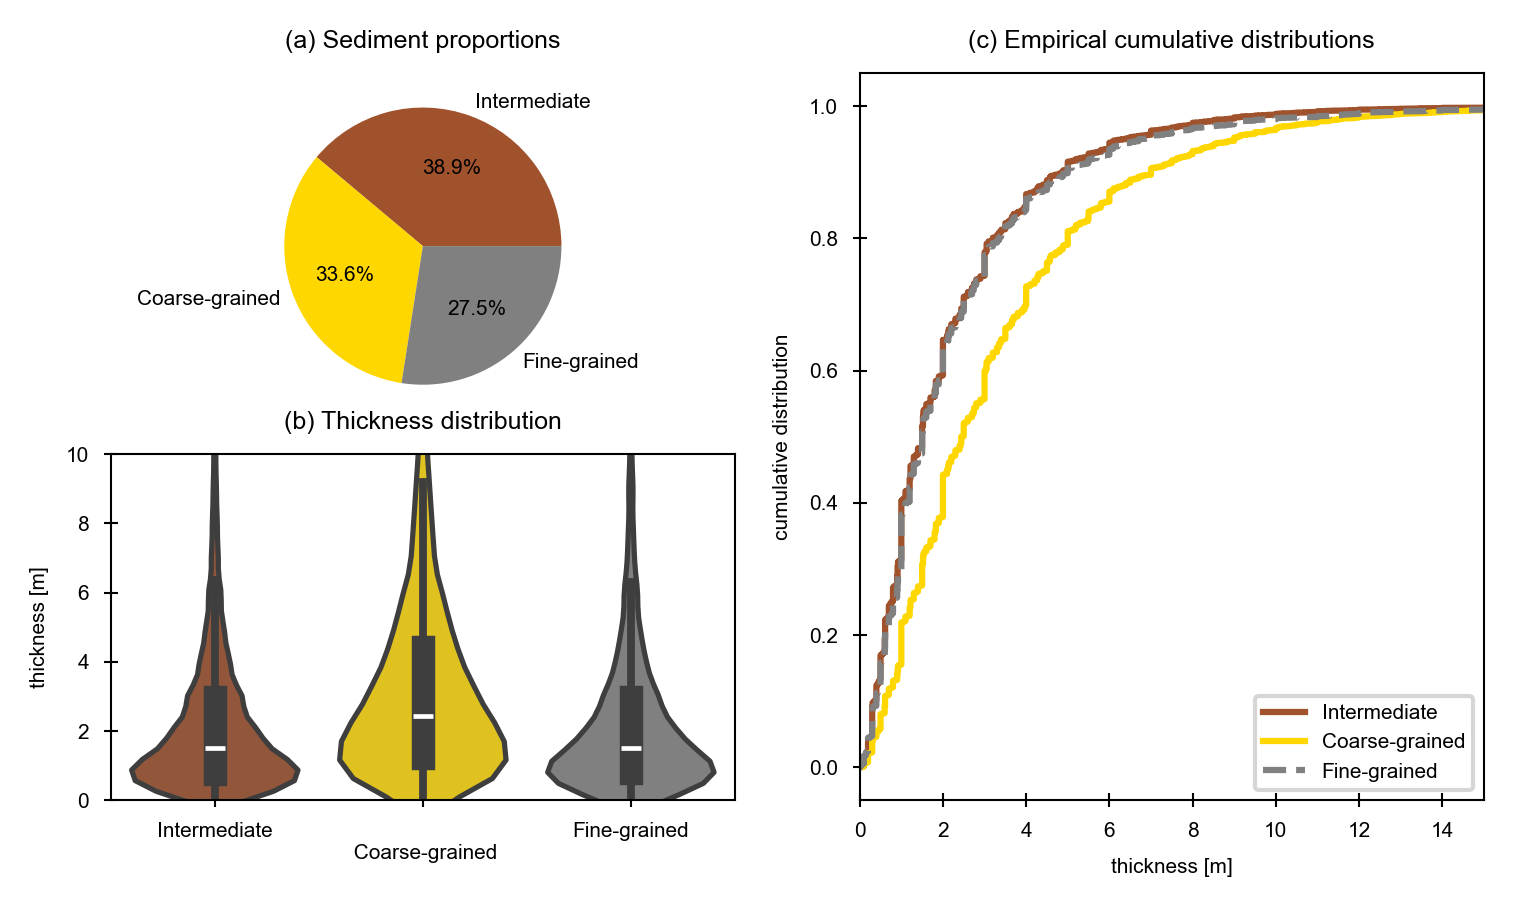

In [25]:
df_processed_log3 = pd.read_csv(df_classified_log_fn) # for violin plot

ix_sediments, df_stats_level_0,x_clay, ecdf_clay, x_sand, ecdf_sand, x_inte, ecdf_inte = get_summary_stats_level_0(df_processed_log3)
plot_summary_stats_level_0(df_processed_log3,thickness_lim,figsize=None,fontsize=None,figFileName=None)


../figures/fig5_level_0_stats_15cm_ft6.png


C:\Users\00102908\my-UWA\LBD-facies-modeling\notebooks\../src\lbd_functions.py:717: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Intermediate','\n Coarse-grained','Fine-grained'])


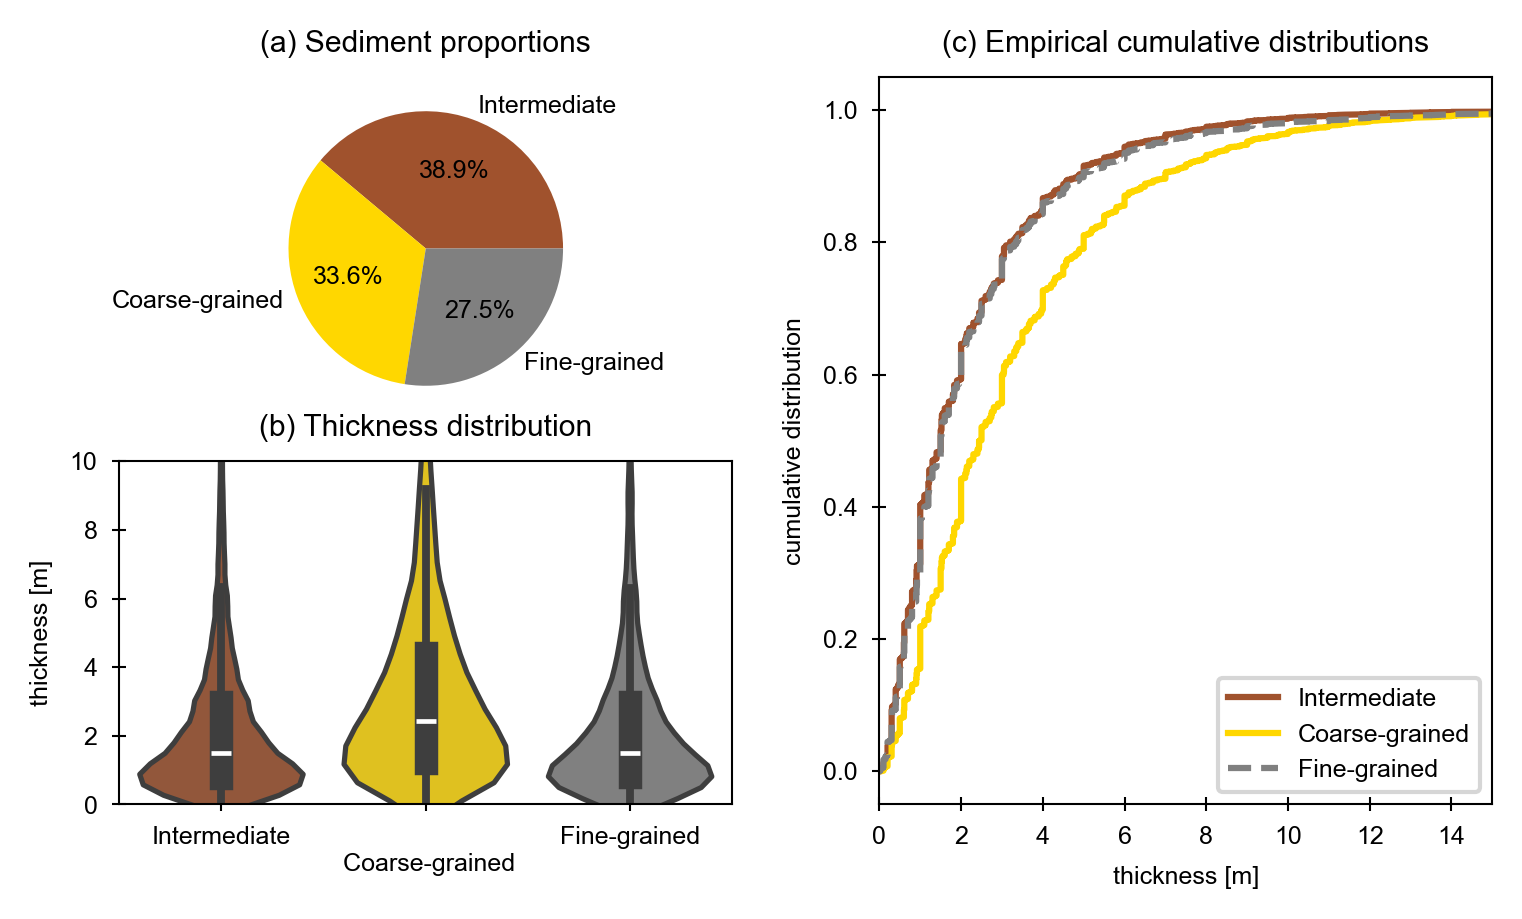

In [26]:
fgw = 15
fts = 6

figFileName = '../figures/fig5_level_0_stats_'+str(fgw)+'cm_ft'+str(fts)+'.png'
print(figFileName)
plot_summary_stats_level_0(df_processed_log3,thickness_lim,figsize=(fgw/2.54,fgw/15*8/2.54),fontsize=fts,figFileName=figFileName)


 ecdf_area_diff: 0.06611652747126402


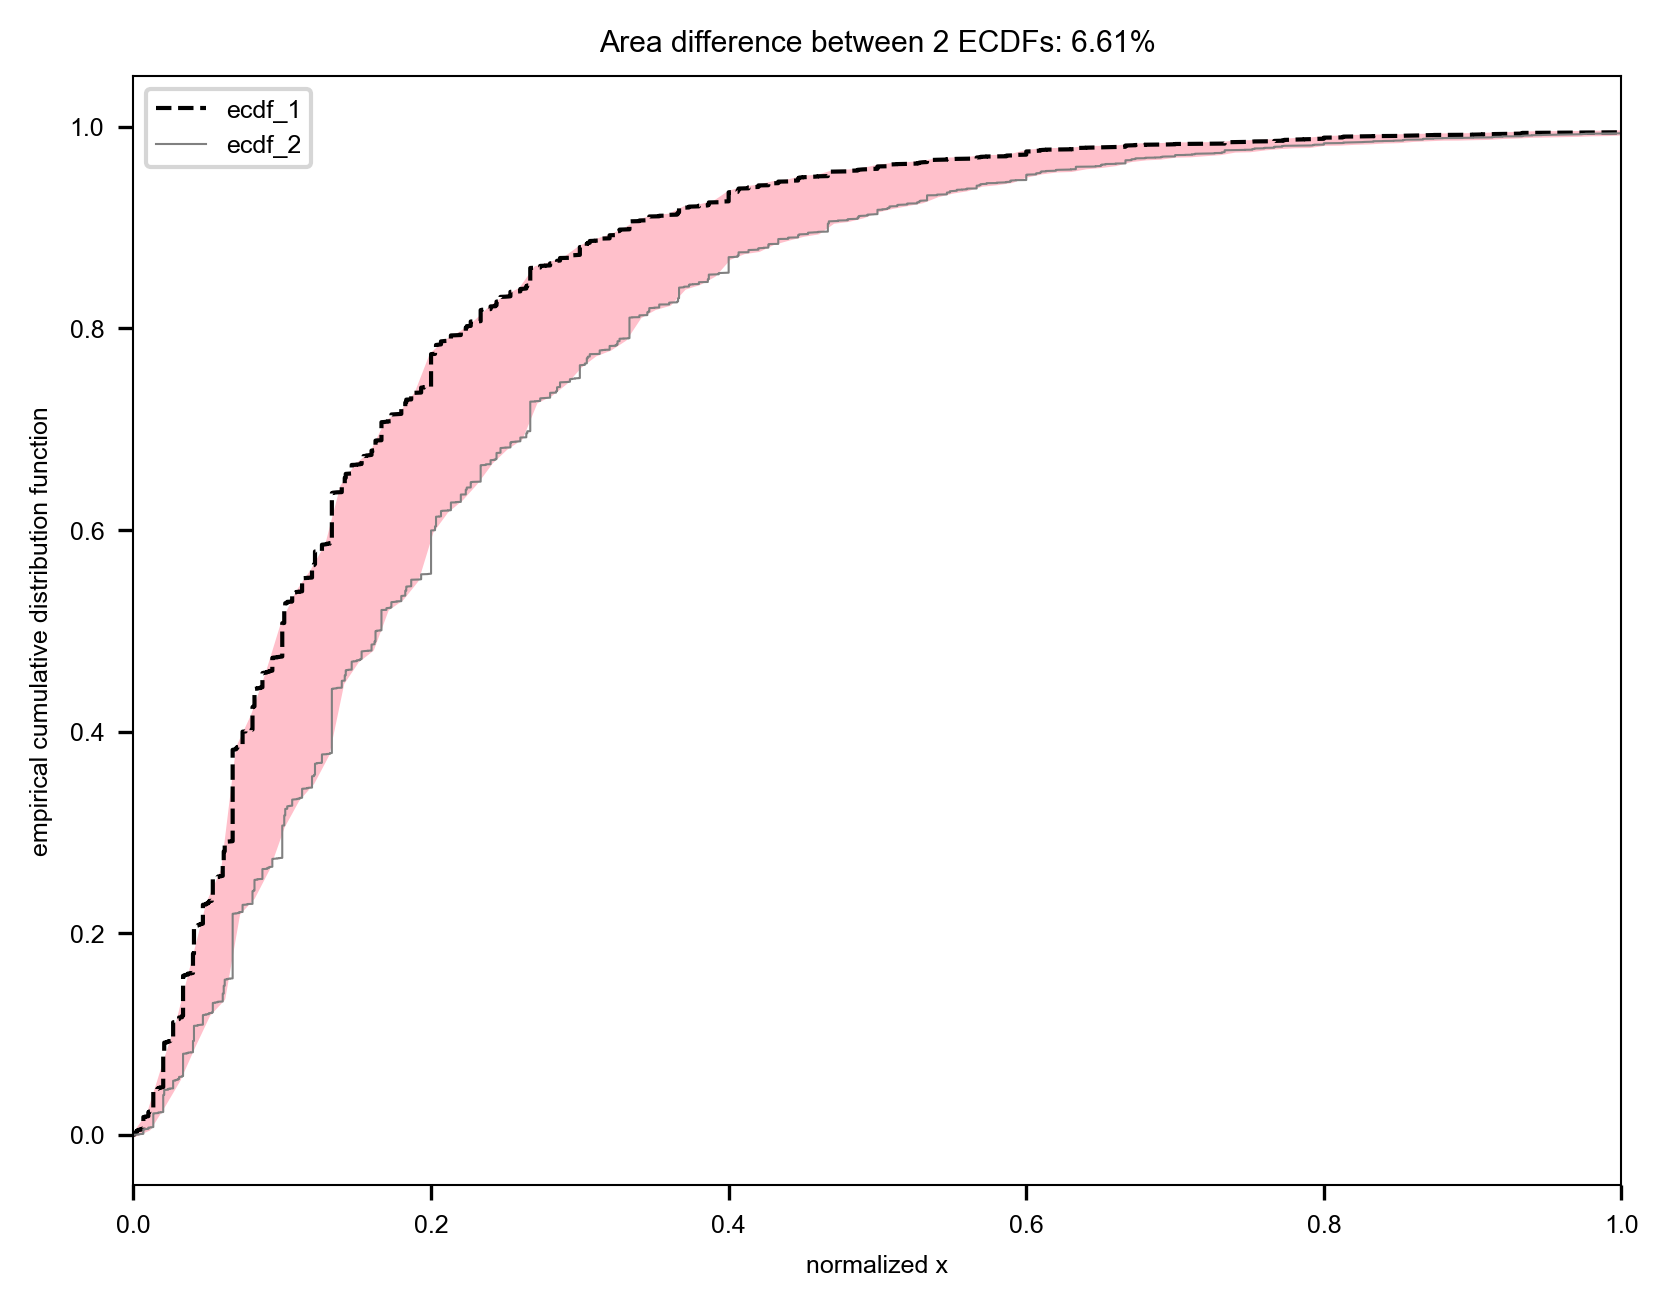

(0.06611652747126402,
 array([0.00000000e+00, 6.66666667e-04, 6.66666667e-04, ...,
        1.66666667e+00, 1.70666667e+00, 2.00000000e+00]),
 array([0.00000000e+00, 1.01729400e-04, 2.03458800e-04, ...,
        9.99796541e-01, 9.99898271e-01, 1.00000000e+00]),
 array([0.        , 0.02085453, 0.06785351, 0.11393693, 0.17202442,
        0.23021363, 0.26337742, 0.38453713, 0.4162767 , 0.45903696,
        0.50712106, 0.53848762, 0.55986775, 0.5861648 , 0.64343845,
        0.66480163, 0.67670397, 0.70742625, 0.71648016, 0.73608003,
        0.77416073, 0.7875551 , 0.79582909, 0.80701933, 0.82115972,
        0.83143438, 0.83906409, 0.86012208, 0.86439471, 0.86985903,
        0.88067141, 0.88697864, 0.89145473, 0.89806714, 0.90696846,
        0.9110885 , 0.91220753, 0.91963377, 0.9214649 , 0.92497457,
        0.93499491, 0.93912061, 0.94109868, 0.94456878, 0.94628688,
        0.94994914, 0.9508647 , 0.95548774, 0.95600203, 0.95768057,
        0.96063072, 0.96266531, 0.96327569, 0.9646999 , 0.96

In [27]:

nbins = 100
xlim = thickness_lim[1]
x_1 = x_clay
x_2 = x_sand
ecdf_1 = ecdf_clay
ecdf_2 = ecdf_sand

get_ecdf_area_difference(x_1,ecdf_1,x_2,ecdf_2,nbins=nbins,xlim=xlim,plot=True,verb=True)

### ECDF and proportion error estimation by repeated sub-sampling

In [28]:

def get_ecdf_cumthick_subsmp(cur_RN_sel,df_processed_log3,cur_level,xlim,x01_vec):
    cur_pl_sel = np.array(np.where((df_processed_log3['RN'].isin(cur_RN_sel)) & 
                                   (df_processed_log3['level_0']==cur_level) & 
                                   (df_processed_log3['thickness'].isnull()==False) )).flatten()
    cur_df = df_processed_log3.loc[cur_pl_sel,['RN','thickness']].reset_index(drop=True,inplace=False)
    cum_thickness = cur_df['thickness'].sum()
    cur_x,cur_ecdf = get_ecdf(cur_df)
    cur_ecdf01 = interp_ecdf_normalize_x(cur_x,cur_ecdf,xlim,x01_vec)
    return cur_ecdf01,cum_thickness

#
nsubsmp = 200
subsmprate = 0.3
nbins = 100
xlim = thickness_lim[1]
x01_vec = np.linspace(0,1.0,num=(nbins+1), endpoint=True)

nbores = len(df_summary)
subsmpsize = int(np.floor(nbores*subsmprate))

print('nbores: '+str(nbores))
print('subsmpsize: '+str(subsmpsize))

rng = np.random.default_rng(14112023)
rnd_subsmp = np.floor(rng.uniform(0,nbores,(subsmpsize,nsubsmp))).astype('int16')

ecdf_clay_subsmp = np.ones((nbins+1,nsubsmp))*np.nan
ecdf_sand_subsmp = np.ones((nbins+1,nsubsmp))*np.nan
ecdf_inte_subsmp = np.ones((nbins+1,nsubsmp))*np.nan

cum_thickness_clay = np.ones(nsubsmp)*np.nan
cum_thickness_sand = np.ones(nsubsmp)*np.nan
cum_thickness_inte = np.ones(nsubsmp)*np.nan

for i in range(nsubsmp):
    cur_RN_sel = df_summary.loc[rnd_subsmp[:,i],'RN'].values
    ecdf_clay_subsmp[:,i],cum_thickness_clay[i] = get_ecdf_cumthick_subsmp(cur_RN_sel,df_processed_log3,'Clay',xlim,x01_vec)
    ecdf_sand_subsmp[:,i],cum_thickness_sand[i] = get_ecdf_cumthick_subsmp(cur_RN_sel,df_processed_log3,'Sands',xlim,x01_vec)
    ecdf_inte_subsmp[:,i],cum_thickness_inte[i] = get_ecdf_cumthick_subsmp(cur_RN_sel,df_processed_log3,'Intermediate',xlim,x01_vec)



nbores: 4878
subsmpsize: 1463


In [29]:
cum_thickness_total = cum_thickness_clay + cum_thickness_sand + cum_thickness_inte
prop_clay = cum_thickness_clay/cum_thickness_total
prop_sand = cum_thickness_sand/cum_thickness_total
prop_inte = cum_thickness_inte/cum_thickness_total


In [30]:
# ecdf: 5-95 pctiles + mean
ecdf_clay_mean_p5_p95 = np.ones((nbins+1,3))*np.nan
ecdf_sand_mean_p5_p95 = np.ones((nbins+1,3))*np.nan
ecdf_inte_mean_p5_p95 = np.ones((nbins+1,3))*np.nan

ecdf_clay_mean_p5_p95[:,0] = np.mean(ecdf_clay_subsmp,axis=1)
ecdf_clay_mean_p5_p95[:,1:] = np.percentile(ecdf_clay_subsmp,[5,95],axis=1).T

ecdf_sand_mean_p5_p95[:,0] = np.mean(ecdf_sand_subsmp,axis=1)
ecdf_sand_mean_p5_p95[:,1:] = np.percentile(ecdf_sand_subsmp,[5,95],axis=1).T

ecdf_inte_mean_p5_p95[:,0] = np.mean(ecdf_inte_subsmp,axis=1)
ecdf_inte_mean_p5_p95[:,1:] = np.percentile(ecdf_inte_subsmp,[5,95],axis=1).T


# prop: 5-95 pctiles + mean
prop_clay_mean_p5_p95 = np.ones(3)*np.nan
prop_sand_mean_p5_p95 = np.ones(3)*np.nan
prop_inte_mean_p5_p95 = np.ones(3)*np.nan

prop_clay_mean_p5_p95[0] = np.mean(prop_clay)
prop_clay_mean_p5_p95[1:] = np.percentile(prop_clay,[5,95])

prop_sand_mean_p5_p95[0] = np.mean(prop_sand)
prop_sand_mean_p5_p95[1:] = np.percentile(prop_sand,[5,95])

prop_inte_mean_p5_p95[0] = np.mean(prop_inte)
prop_inte_mean_p5_p95[1:] = np.percentile(prop_inte,[5,95])



In [31]:
ecdf_clay_interp = interp_ecdf_normalize_x(x_clay, ecdf_clay,xlim,x01_vec)
ecdf_sand_interp = interp_ecdf_normalize_x(x_sand, ecdf_sand,xlim,x01_vec)
ecdf_inte_interp = interp_ecdf_normalize_x(x_inte, ecdf_inte,xlim,x01_vec)


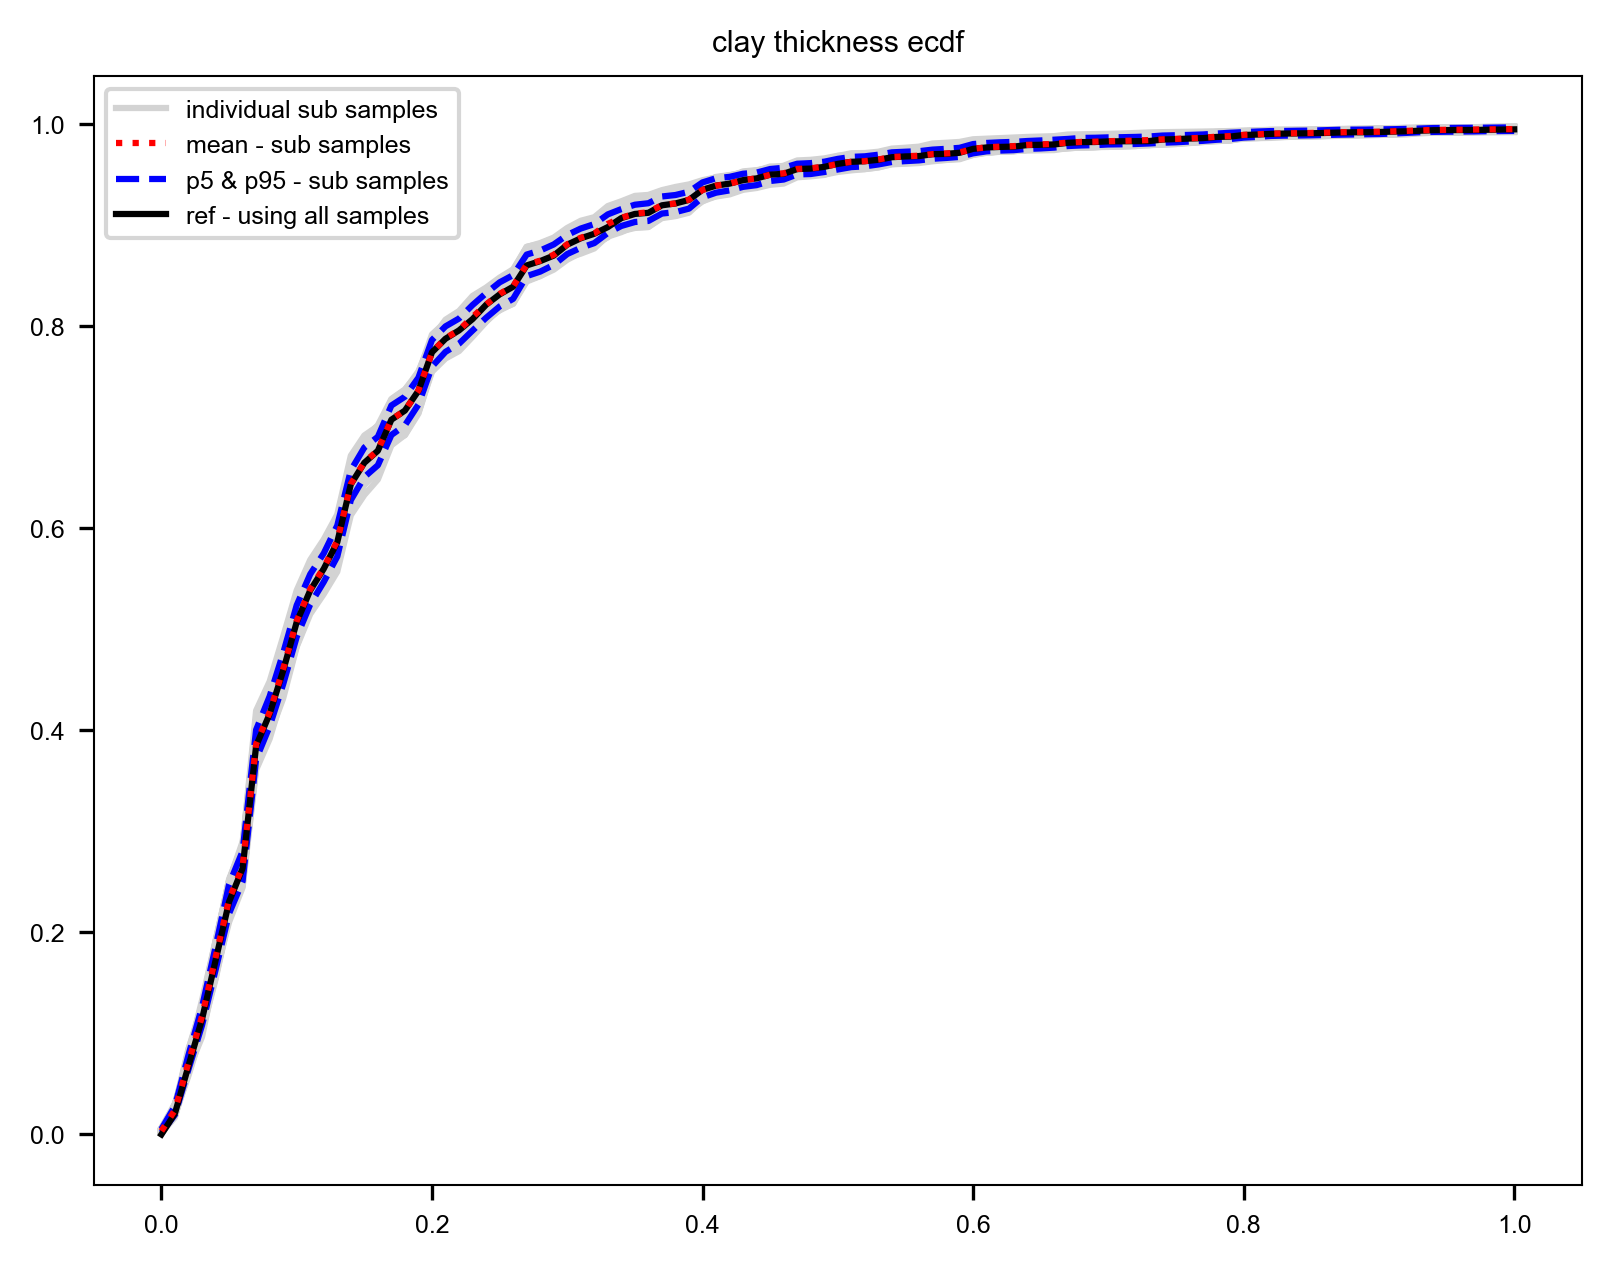

In [32]:
# CHECK PLOTS?
plt.figure(dpi=300)
plt.plot(x01_vec,ecdf_clay_subsmp,'-',color='lightgrey',label = 'individual sub samples')
plt.plot(x01_vec,ecdf_clay_mean_p5_p95[:,1:],'--',color='blue',label = 'p5 & p95 - sub samples')
plt.plot(x01_vec,ecdf_clay_interp,'-k',label = 'ref - using all samples')

plt.plot(x01_vec,ecdf_clay_mean_p5_p95[:,0],':',color='red',label = 'mean - sub samples')

handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')

plt.title('clay thickness ecdf')
plt.show()

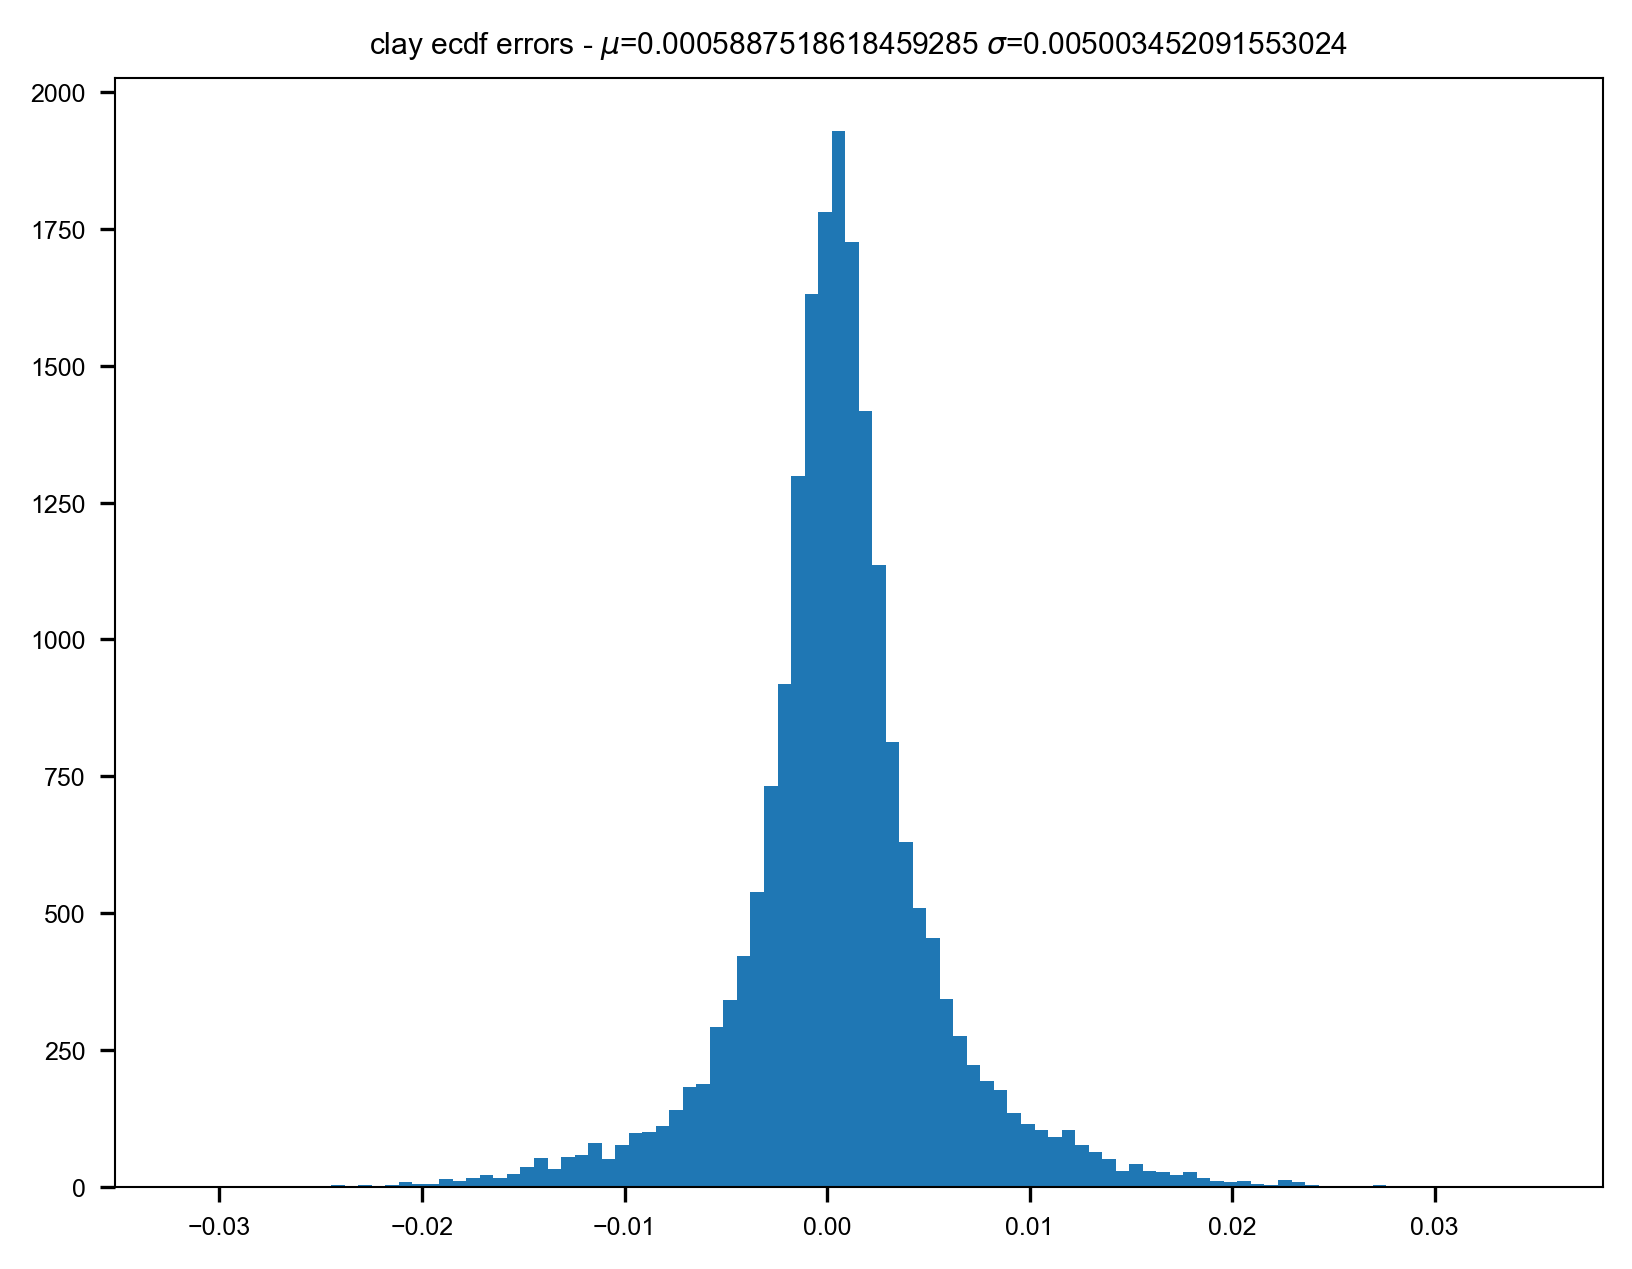

In [33]:
ecdf_clay_errors = ecdf_clay_subsmp - ecdf_clay_interp[:,None]
ecdf_sand_errors = ecdf_sand_subsmp - ecdf_sand_interp[:,None]
ecdf_inte_errors = ecdf_inte_subsmp - ecdf_inte_interp[:,None]

plt.figure(dpi=300)
plt.hist(ecdf_clay_errors.flatten(),100)
plt.title('clay ecdf errors - $\mu$='+str(np.mean(ecdf_clay_errors.flatten()))+' $\sigma$='+str(np.std(ecdf_clay_errors.flatten())))
plt.show()

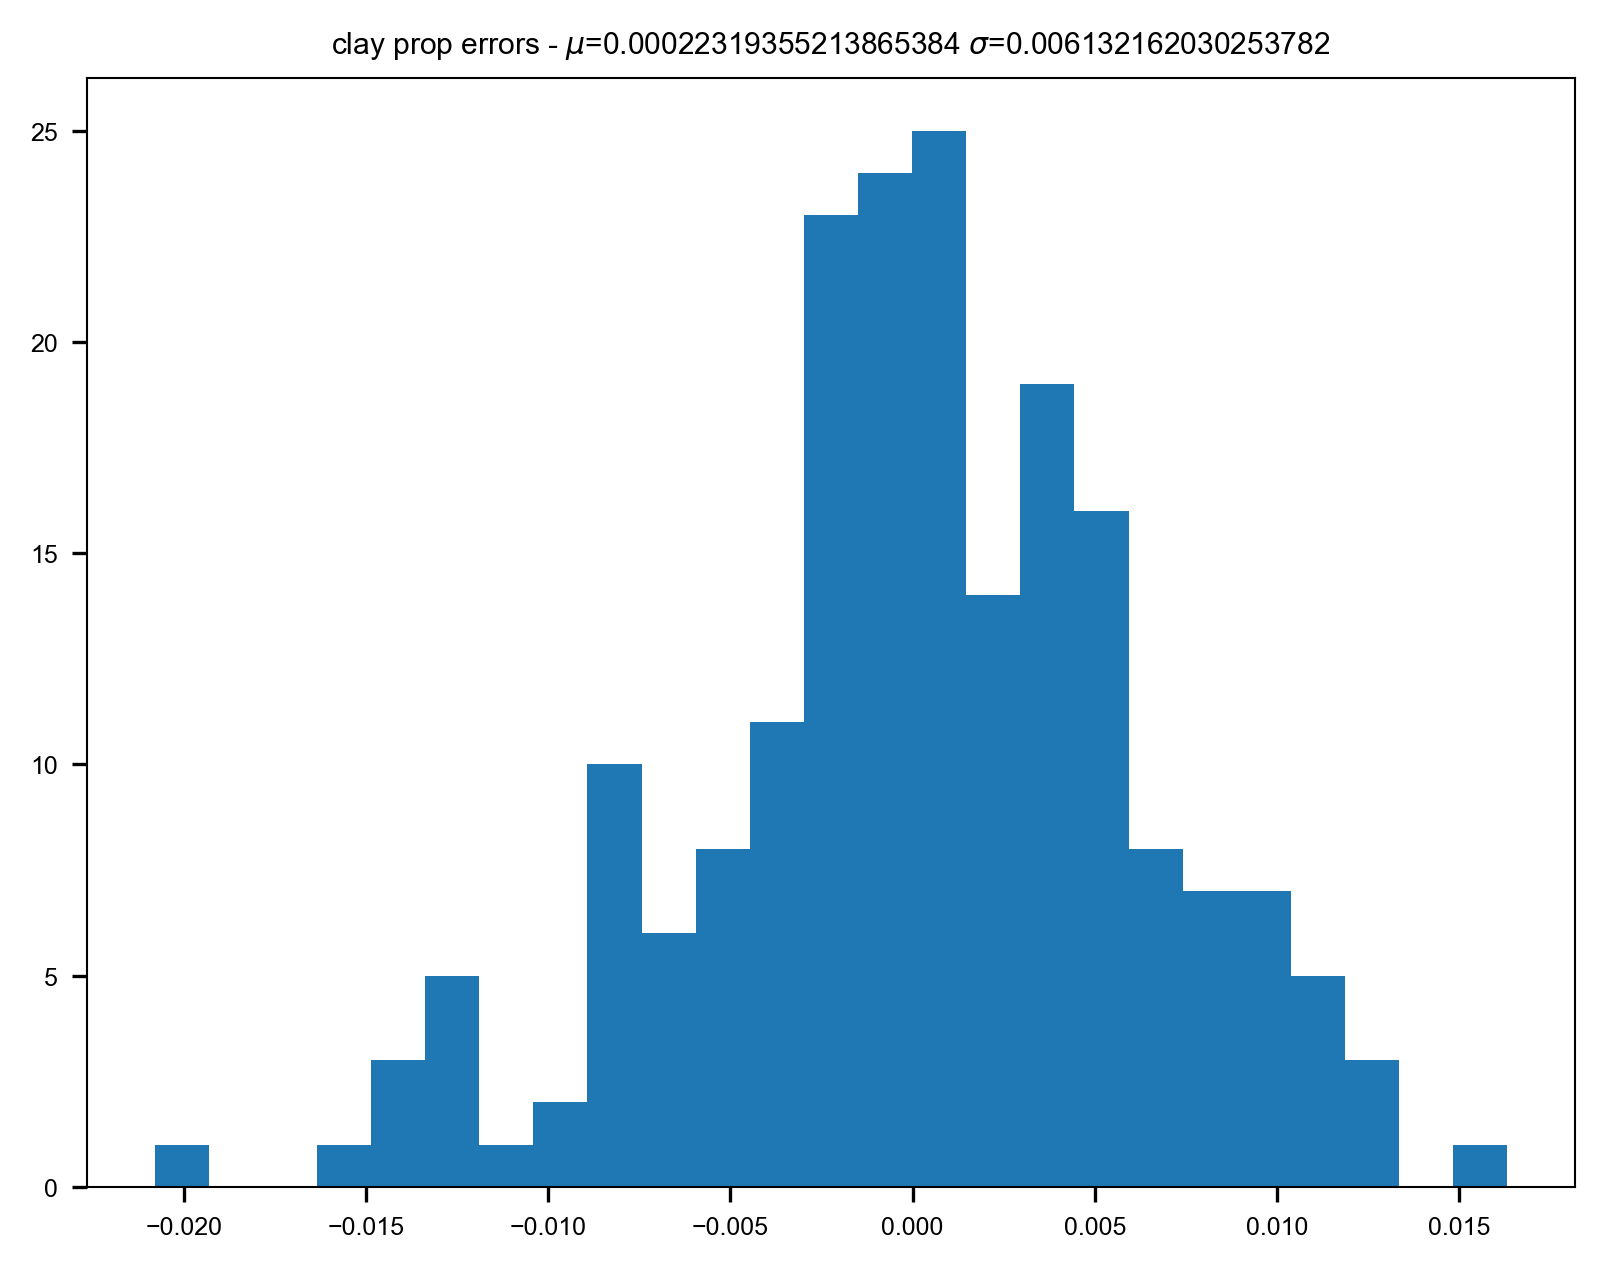

In [34]:
prop_clay_errors = prop_clay - df_stats_level_0.loc['Clay','proportion']
prop_sand_errors = prop_sand - df_stats_level_0.loc['Sands','proportion']
prop_inte_errors = prop_inte - df_stats_level_0.loc['Intermediate','proportion']


plt.figure(dpi=300)
plt.hist(prop_clay_errors,25)
plt.title('clay prop errors - $\mu$='+str(np.mean(prop_clay_errors))+' $\sigma$='+str(np.std(prop_clay_errors)))
plt.show()

In [35]:
# ecdf error: 5-95 pctiles + mean
ecdf_clay_area_err = np.sum(np.abs(ecdf_clay_errors),axis=1)/nbins
ecdf_clay_area_err_mean_p5_p95 = np.ones(3)*np.nan
ecdf_clay_area_err_mean_p5_p95[0] = np.mean(ecdf_clay_area_err)
ecdf_clay_area_err_mean_p5_p95[1:] = np.percentile(ecdf_clay_area_err,[5,95])
print('ecdf_clay_area_err_mean_p5_p95: '+str(ecdf_clay_area_err_mean_p5_p95))

# prop error: 5-95 pctiles + mean
prop_clay_err_mean_p5_p95 = np.ones(3)*np.nan
prop_clay_err_mean_p5_p95[0] = np.mean(prop_clay_errors)
prop_clay_err_mean_p5_p95[1:] = np.percentile(prop_clay_errors,[5,95])
print('prop_clay_err_mean_p5_p95: '+str(prop_clay_err_mean_p5_p95))

# ecdf error: 5-95 pctiles + mean
ecdf_sand_area_err = np.sum(np.abs(ecdf_sand_errors),axis=1)/nbins
ecdf_sand_area_err_mean_p5_p95 = np.ones(3)*np.nan
ecdf_sand_area_err_mean_p5_p95[0] = np.mean(ecdf_sand_area_err)
ecdf_sand_area_err_mean_p5_p95[1:] = np.percentile(ecdf_sand_area_err,[5,95])
print('ecdf_sand_area_err_mean_p5_p95: '+str(ecdf_sand_area_err_mean_p5_p95))

# prop error: 5-95 pctiles + mean
prop_sand_err_mean_p5_p95 = np.ones(3)*np.nan
prop_sand_err_mean_p5_p95[0] = np.mean(prop_sand_errors)
prop_sand_err_mean_p5_p95[1:] = np.percentile(prop_sand_errors,[5,95])
print('prop_sand_err_mean_p5_p95: '+str(prop_sand_err_mean_p5_p95))

# ecdf error: 5-95 pctiles + mean
ecdf_inte_area_err = np.sum(np.abs(ecdf_inte_errors),axis=1)/nbins
ecdf_inte_area_err_mean_p5_p95 = np.ones(3)*np.nan
ecdf_inte_area_err_mean_p5_p95[0] = np.mean(ecdf_inte_area_err)
ecdf_inte_area_err_mean_p5_p95[1:] = np.percentile(ecdf_inte_area_err,[5,95])
print('ecdf_inte_area_err_mean_p5_p95: '+str(ecdf_inte_area_err_mean_p5_p95))

# prop error: 5-95 pctiles + mean
prop_inte_err_mean_p5_p95 = np.ones(3)*np.nan
prop_inte_err_mean_p5_p95[0] = np.mean(prop_inte_errors)
prop_inte_err_mean_p5_p95[1:] = np.percentile(prop_inte_errors,[5,95])
print('prop_inte_err_mean_p5_p95: '+str(prop_inte_err_mean_p5_p95))


ecdf_clay_area_err_mean_p5_p95: [0.00678714 0.00198035 0.01467255]
prop_clay_err_mean_p5_p95: [ 0.00022319 -0.0105801   0.01002011]
ecdf_sand_area_err_mean_p5_p95: [0.00958104 0.00269445 0.01838369]
prop_sand_err_mean_p5_p95: [-0.0007283  -0.01240483  0.01176044]
ecdf_inte_area_err_mean_p5_p95: [0.00518058 0.00132291 0.01158136]
prop_inte_err_mean_p5_p95: [ 0.0005051  -0.01088105  0.01219764]


In [36]:
df_stats_level_0

,proportion
level_0,
Clay,0.274579
Intermediate,0.389009
Sands,0.336412


In [37]:
print('prop_clay_mean_p5_p95: '+str(prop_clay_mean_p5_p95))
print('prop_sand_mean_p5_p95: '+str(prop_sand_mean_p5_p95))
print('prop_inte_mean_p5_p95: '+str(prop_inte_mean_p5_p95))

prop_clay_mean_p5_p95: [0.27480225 0.26399895 0.28459917]
prop_sand_mean_p5_p95: [0.33568375 0.32400721 0.34817248]
prop_inte_mean_p5_p95: [0.389514   0.37812785 0.40120653]


In [38]:
# SAVE TO PICKLE
f = open(ref_err_fn, 'wb')
pickle.dump([prop_clay_mean_p5_p95, prop_sand_mean_p5_p95, prop_inte_mean_p5_p95,
             prop_clay_err_mean_p5_p95, prop_sand_err_mean_p5_p95, prop_inte_err_mean_p5_p95,
             ecdf_clay_mean_p5_p95, ecdf_sand_mean_p5_p95, ecdf_inte_mean_p5_p95, x01_vec, thickness_lim,
             ecdf_clay_area_err_mean_p5_p95, ecdf_sand_area_err_mean_p5_p95, ecdf_inte_area_err_mean_p5_p95], f)
f.close()
